Imports and Configuration

In [ ]:
# %pip install hf_xet
# %pip uninstall -y torch torchvision torchaudio intel-extension-for-pytorch intel-extension-for-pytorch[xpu]
# %pip install transformers datasets accelerate evaluate peft scikit-learn
# %pip install torch==2.7.0 torchvision==0.22.0 torchaudio==2.7.0 --index-url https://download.pytorch.org/whl/xpu
# %pip install intel-extension-for-pytorch==2.7.10+xpu --extra-index-url https://pytorch-extension.intel.com/release-whl/stable/xpu/us/
# %pip install sentence_transformers faiss-cpu openpyxl
# %pip install graphviz


In [1]:
import re
import os
import gc
import json
import math
import random
import hashlib
import pathlib
import textwrap
from copy import deepcopy
from datetime import datetime, timezone
from collections import Counter
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import spacy
import torch
import faiss
import evaluate
import transformers
from tqdm import tqdm

from datasets import Dataset, DatasetDict, load_dataset
from sentence_transformers import SentenceTransformer, CrossEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset as TorchDataset, DataLoader, WeightedRandomSampler
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AutoModelForSeq2SeqLM,
    Trainer, 
    TrainingArguments, 
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig



# PHASE 1 - Clean and Load the Tickets - Train the classifier

In [2]:
TICKETS_PATH = Path("data/raw/Copy of Tickets_cleaned.xlsx")
HISTORY_PATH = Path("data/raw/Ticket history 3.xlsx")

ARTIFACTS = Path("artifacts"); ARTIFACTS.mkdir(parents=True, exist_ok=True)


History Cell 1 - Load both Excel files & standardise column names

In [3]:
# Load and normalise datasets
def _upper(df):
    df = df.copy()
    df.columns = [c.upper() for c in df.columns]
    return df

tickets_raw = _upper(pd.read_excel(TICKETS_PATH))
history_raw = _upper(pd.read_excel(HISTORY_PATH))

# Convert date columns
for c in ["RECEIVEDDATE", "COMPLETEDDATE"]:
    if c in tickets_raw:
        tickets_raw[c] = pd.to_datetime(tickets_raw[c], errors="coerce")
if "CREATEDATE" in history_raw:
    history_raw["CREATEDATE"] = pd.to_datetime(history_raw["CREATEDATE"], errors="coerce")

# Normalise category names
def _norm_cat(x: str) -> str:
    s = (x or "").upper()
    if "V4" in s: return "S1000v4"
    if "V3" in s: return "S1000v3"
    return "S1000"

tickets_raw["CATEGORY_NORM"] = tickets_raw.get("CATEGORY", "").astype(str).apply(_norm_cat)

# Clean history data 
RE_TICKET_RCVD  = re.compile(r"\bTICKET\s+RECEIVED\b", re.I)
RE_STATUS_MSG   = re.compile(r"\b(has\s+changed\s+its\s+status\s+to|status\s+changed)\b", re.I)
RE_LOGGED_CALL  = re.compile(r"\bsupport\s+call\s+has\s+been\s+logged\b", re.I)
RE_SIGNATURE    = re.compile(r"\b(kind regards|regards|thanks|thank you|cheers)\b", re.I)
RE_DISCLAIMER   = re.compile(r"(confidentiality|does not accept responsibility|virus|warning:)", re.I)

def _hist_is_noise(shortdesc: str, act: str) -> bool:
    s1 = (shortdesc or "")
    s2 = (act or "")
    blob = f"{s1} {s2}"
    if RE_TICKET_RCVD.search(blob):  return True
    if RE_STATUS_MSG.search(blob):   return True
    if RE_LOGGED_CALL.search(blob):  return True
    if RE_SIGNATURE.search(blob):    return True
    if RE_DISCLAIMER.search(blob):   return True
    return False

hist = history_raw.copy()
hist["SHORTDESC"]    = hist.get("SHORTDESC", "").fillna("").astype(str)
hist["ACTIVITYDESC"] = hist.get("ACTIVITYDESC", "").fillna("").astype(str)

orig_hist_rows = len(hist)
hist = hist[~hist.apply(lambda r: _hist_is_noise(r["SHORTDESC"], r["ACTIVITYDESC"]), axis=1)]

# Compact per-row line 
hist["LINE"] = hist.apply(
    lambda r: f"{pd.to_datetime(r['CREATEDATE'], errors='coerce'):%Y-%m-%d %H:%M} — {r['SHORTDESC']} {r['ACTIVITYDESC']}".strip(),
    axis=1,
)

# Order & aggregate to one HISTORY_TEXT per ticket
hist_sorted = hist.sort_values(["TICKETID", "CREATEDATE"], na_position="last")
hist_agg = hist_sorted.groupby("TICKETID")["LINE"].apply(
    lambda x: " \n".join([s for s in x if s])
).reset_index().rename(columns={"LINE": "HISTORY_TEXT"})

# Merge back and ensure text columns exist
tickets = tickets_raw.merge(hist_agg, on="TICKETID", how="left")
tickets["HISTORY_TEXT"] = tickets["HISTORY_TEXT"].fillna("")

for c in ["SUBJECT","PROBLEM","SOLUTION"]:
    if c not in tickets: tickets[c] = ""
tickets[["SUBJECT","PROBLEM","SOLUTION"]] = tickets[["SUBJECT","PROBLEM","SOLUTION"]].fillna("").astype(str)

print("Data loading complete.")
print(f"History rows kept: {len(hist)}/{orig_hist_rows} ({len(hist)/max(1,orig_hist_rows):.1%})")
print("Tickets shape:", tickets.shape)
print("Columns:", list(tickets.columns)[:15], "…")
print("\nSample HISTORY_TEXT:\n", tickets["HISTORY_TEXT"].iloc[0][:400])


Data loading complete.
History rows kept: 15558/41334 (37.6%)
Tickets shape: (5275, 16)
Columns: ['TICKETID', 'ALTERNATEKEYSUFFIX', 'AREA', 'CATEGORY', 'ISSUE', 'RECEIVEDDATE', 'COMPLETEDDATE', 'SUBJECT', 'URGENCYCODE', 'PROBLEM', 'SOLUTION', 'RESULTIONSUMMARY', 'ACCOUNTID', 'ACCOUNT', 'CATEGORY_NORM'] …

Sample HISTORY_TEXT:
 2025-05-23 11:32 — 
2025-05-23 13:09 —  [REDACTED_NAME] like batch was imported and the local amount differs to the currency amount by the VAT - ALL local suppliers - no currency. 
2025-05-23 14:03 —  [REDACTED_NAME] local_amount to be the same as currency_amount for batch PI7268. [REDACTED_NAME] will bring the AP in line with the amended G/L journal.

--begin tran
--update scheme.plitemm set loca


Build URGENCYCODE 

In [9]:
def build_urgency_code(df: pd.DataFrame) -> pd.Series:
    # Return existing numeric URGENCYCODE if available
    if "URGENCYCODE" in df.columns:
        return pd.to_numeric(df["URGENCYCODE"], errors="coerce")
    
    # Default to non-escalated if no urgency info
    if "URGENCY" not in df.columns:
        return pd.Series([9]*len(df), index=df.index, dtype="float64")
    
    s = df["URGENCY"].copy()
    # Try numeric conversion first
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().any() and s_num.isna().mean() < 0.5:
        return s_num
    
    # '5' being the most critical and going down in priority onwards
    def map_text(val: str) -> int:
        t = str(val).strip().upper()
        if any(k in t for k in ["P1","CRIT","CRITICAL","SEV1","URGENT","IMMEDIATE","SYSTEM DOWN"]): return 5
        if any(k in t for k in ["P2","HIGH","SEV2","BUSINESS CRITICAL"]): return 4
        if any(k in t for k in ["P3","MEDIUM","NORMAL","STD","STANDARD ISSUE"]): return 3
        if any(k in t for k in ["P4","LOW","MINOR"]): return 2
        return 1

    return s.astype(str).map(map_text)

tickets["URGENCYCODE"] = build_urgency_code(tickets)
print("Urgency summary:\n", tickets["URGENCYCODE"].describe())
print("Unique raw URGENCY values (if any):", tickets["URGENCY"].unique()[:10] if "URGENCY" in tickets else "—")


Urgency summary:
 count    5275.000000
mean        2.799621
std         0.697142
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: URGENCYCODE, dtype: float64
Unique raw URGENCY values (if any): —


In [10]:
# Build escalation labels from URGENCYCODE
tickets["URGENCYCODE"] = pd.to_numeric(tickets["URGENCYCODE"], errors="coerce")
y_esc = (tickets["URGENCYCODE"] <= 2).astype(int).values

print("Rows:", len(tickets))
print("\nCategory distribution (top 10):")
print(tickets["CATEGORY"].value_counts(dropna=False).head(10))

print("\nUrgency summary:")
print(tickets["URGENCYCODE"].describe())
print("Escalation positive ratio (URGENCYCODE ≤ 2):", y_esc.mean())

# Text length diagnostics
for c in ["SUBJECT","PROBLEM","SOLUTION","HISTORY_TEXT"]:
    if c in tickets.columns:
        lens = tickets[c].fillna("").astype(str).str.len()
        print(f"\n{c}: mean={lens.mean():.1f}, median={lens.median():.1f}, 95p={lens.quantile(0.95):.0f}, empty%={(lens==0).mean():.1%}")


Rows: 5275

Category distribution (top 10):
CATEGORY
S1000v4        4197
S1000v3         768
S1000           293
S1000v4/CRM      16
S1000/CRM         1
Name: count, dtype: int64

Urgency summary:
count    5275.000000
mean        2.799621
std         0.697142
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: URGENCYCODE, dtype: float64
Escalation positive ratio (URGENCYCODE ≤ 2): 0.11658767772511848

SUBJECT: mean=19.3, median=15.0, 95p=52, empty%=14.1%

PROBLEM: mean=219.7, median=158.0, 95p=618, empty%=1.4%

SOLUTION: mean=130.2, median=81.0, 95p=377, empty%=0.8%

HISTORY_TEXT: mean=751.5, median=235.0, 95p=3196, empty%=12.6%


C:\Users\gupta\AppData\Local\Temp\ipykernel_10280\2559347300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


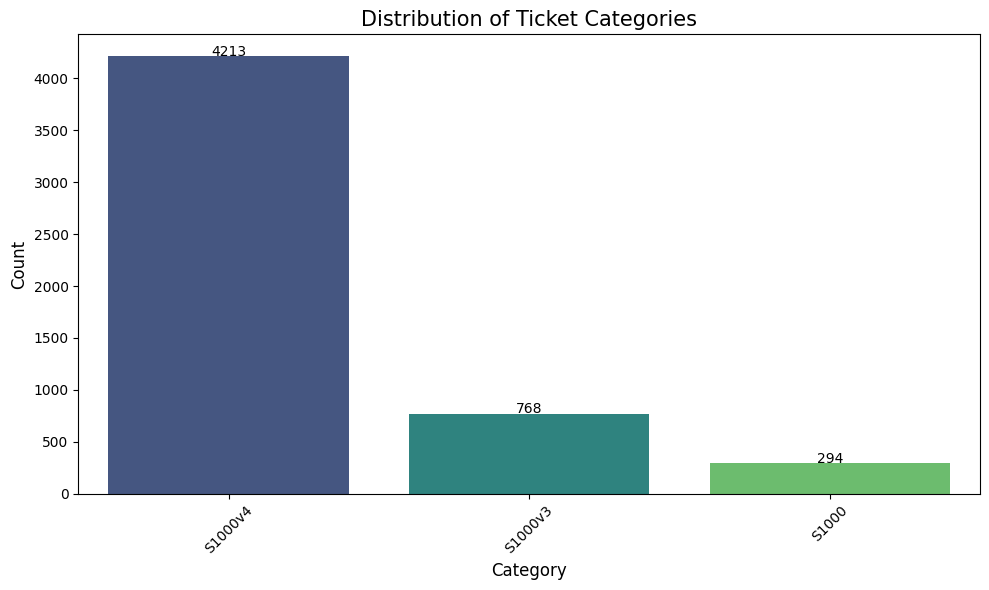

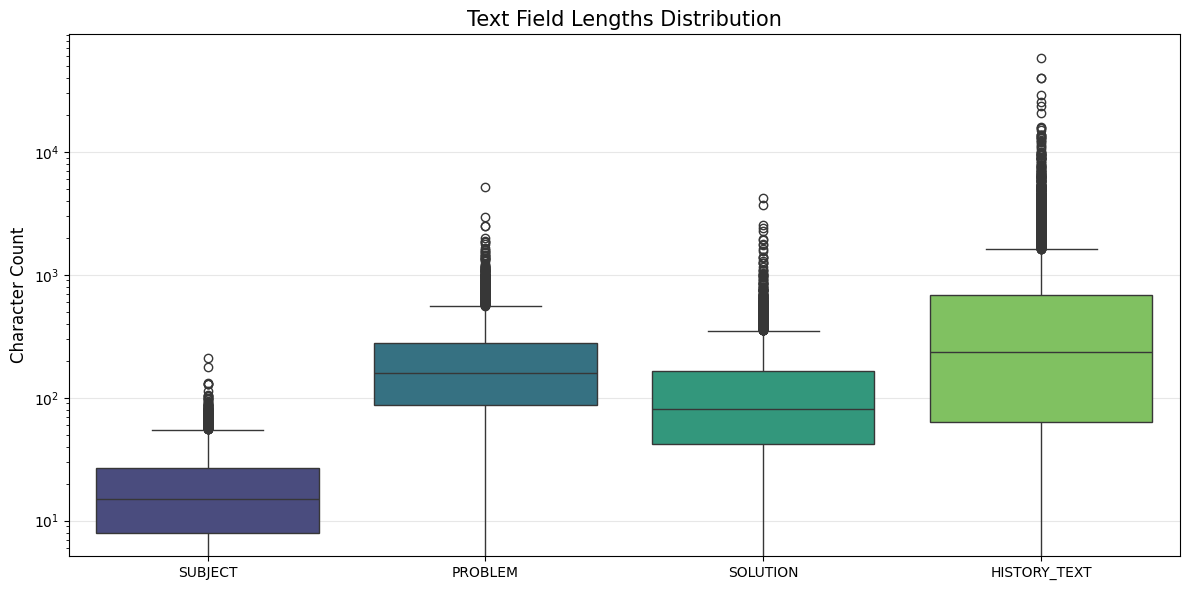

In [11]:
plt.figure(figsize=(10, 6))
category_counts = tickets["CATEGORY_NORM"].value_counts()
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Ticket Categories', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45)

for i, count in enumerate(category_counts.values):
    ax.text(i, count + 5, f'{count}', ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
text_fields = ['SUBJECT', 'PROBLEM', 'SOLUTION', 'HISTORY_TEXT']
field_lengths = pd.DataFrame({
    field: tickets[field].fillna('').astype(str).str.len() 
    for field in text_fields if field in tickets.columns
})

sns.boxplot(data=field_lengths, palette='viridis')
plt.title('Text Field Lengths Distribution', fontsize=15)
plt.ylabel('Character Count', fontsize=12)
plt.yscale('log')  
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### PII Analysis

In [12]:
nlp = spacy.load("en_core_web_sm", disable=["parser","lemmatizer"])

RE_EMAIL = re.compile(r"[\w\.\-]+@[\w\.-]+", re.I)
RE_PHONE = re.compile(r"\+?\d[\d\-\s]{8,}\d")

def count_pii_hits(text: str):
    if not isinstance(text, str) or not text:
        return (0,0,0)
    doc = nlp(text)
    ents = sum(1 for e in doc.ents if e.label_ in {"PERSON","ORG","GPE","LOC"})
    emails = len(RE_EMAIL.findall(text))
    phones = len(RE_PHONE.findall(text))
    return ents, emails, phones

scan_cols = [c for c in ["SUBJECT","PROBLEM","SOLUTION","HISTORY_TEXT"] if c in tickets.columns]
pii_counts = {}
for c in scan_cols:
    arr = tickets[c].fillna("").astype(str).tolist()
    ents, emails, phones = np.array([count_pii_hits(x) for x in arr]).sum(axis=0)
    pii_counts[c] = {"NER_ents": int(ents), "emails": int(emails), "phones": int(phones)}
pii_counts


{'SUBJECT': {'NER_ents': 1156, 'emails': 0, 'phones': 3},
 'PROBLEM': {'NER_ents': 4679, 'emails': 5, 'phones': 202},
 'SOLUTION': {'NER_ents': 4777, 'emails': 2, 'phones': 51},
 'HISTORY_TEXT': {'NER_ents': 11428, 'emails': 12, 'phones': 17748}}

 PII Masking

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser","lemmatizer"])

RE_EMAIL = re.compile(r"[\w\.\-]+@[\w\.-]+", re.I)
RE_PHONE = re.compile(r"\+?\d[\d\-\s]{8,}\d")

MASK_EMAILS   = True
MASK_PHONES   = True

def mask_text(text: str) -> str:
    if not isinstance(text, str) or not text:
        return text
    original = text

    # Regex masking
    if MASK_EMAILS:
        text = RE_EMAIL.sub("[REDACTED_EMAIL]", text)
    if MASK_PHONES:
        text = RE_PHONE.sub("[REDACTED_PHONE]", text)
    return text

cols_to_mask = [c for c in ["SUBJECT","PROBLEM","SOLUTION","HISTORY_TEXT"] if c in tickets.columns]
for c in cols_to_mask:
    tickets[c] = tickets[c].fillna("").astype(str).apply(mask_text)

print("Masking applied to:", cols_to_mask)

Masking applied to: ['SUBJECT', 'PROBLEM', 'SOLUTION', 'HISTORY_TEXT']


 Verify PII after masking

In [60]:
def count_pii_hits_simple(text: str):
    if not isinstance(text, str) or not text:
        return (0,0)
    emails = len(RE_EMAIL.findall(text))
    phones = len(RE_PHONE.findall(text))
    return emails, phones

post_counts = {}
for c in cols_to_mask:
    arr = tickets[c].tolist()
    emails, phones = np.array([count_pii_hits_simple(x) for x in arr]).sum(axis=0)
    post_counts[c] = {"emails": int(emails), "phones": int(phones)}
post_counts


{'SUBJECT': {'emails': 0, 'phones': 0},
 'PROBLEM': {'emails': 0, 'phones': 0},
 'SOLUTION': {'emails': 0, 'phones': 0},
 'HISTORY_TEXT': {'emails': 0, 'phones': 0}}

Build texts to embed (w/o history)

In [ ]:
INCLUDE_HISTORY_IN_EMBEDDINGS = False 

TEXT_COLS = ["SUBJECT","PROBLEM"]
if INCLUDE_HISTORY_IN_EMBEDDINGS and "HISTORY_TEXT" in tickets.columns:
    TEXT_COLS = TEXT_COLS + ["HISTORY_TEXT"]

texts = tickets[TEXT_COLS].fillna("").astype(str).agg(" ".join, axis=1).tolist()
lengths = pd.Series([len(t) for t in texts])
print("Text length summary → mean:", lengths.mean(), "median:", lengths.median(), "95p:", lengths.quantile(0.95))


Text length summary → mean: 371.1044549763033 median: 293.0 95p: 904.9000000000005


Encode embeddings (MiniLM)

In [12]:
ARTIFACTS = Path("artifacts"); ARTIFACTS.mkdir(parents=True, exist_ok=True)

embedder = SentenceTransformer("all-MiniLM-L6-v2")
print("Encoding embeddings.")
emb = embedder.encode(texts, batch_size=128, show_progress_bar=True, normalize_embeddings=True)

np.save(ARTIFACTS / "embeddings.npy", emb)
print("Embeddings shape:", emb.shape)


Encoding embeddings.


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Embeddings shape: (5275, 384)


Save and load embedded tickets for phase 1

In [13]:

PROCESSED_CSV   = Path("data/processed/tickets_processed_v1.csv")

PROCESSED_CSV.parent.mkdir(parents=True, exist_ok=True)

In [14]:
tickets = pd.read_csv(PROCESSED_CSV, low_memory=False, parse_dates=["RECEIVEDDATE","COMPLETEDDATE"])
print("Loaded tickets:", tickets.shape)


Loaded tickets: (5275, 16)


FAISS index wothout History 

In [13]:
print("Building the FAISS index")
index = faiss.IndexFlatIP(emb.shape[1])  
index.add(emb.astype(np.float32))
faiss.write_index(index, str(ARTIFACTS / "faiss_index.bin"))
print("Index vectors:", index.ntotal)

# Quick retrieval metric using CATEGORY label
from sklearn.preprocessing import LabelEncoder
le_cat_tmp = LabelEncoder().fit(tickets["CATEGORY"].fillna("UNKNOWN"))
y_cat_tmp  = le_cat_tmp.transform(tickets["CATEGORY"].fillna("UNKNOWN"))

def precision_at_k(emb, labels, k=5, sample=2000, seed=42):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(emb), size=min(sample, len(emb)), replace=False)
    hits, total = 0, 0
    for i in idxs:
        _, I = index.search(emb[i:i+1].astype(np.float32), k+1)
        neigh = I[0][1:]  # drop self
        hits += sum(labels[j] == labels[i] for j in neigh)
        total += k
    return hits/total if total else 0.0

print("Retrieval Precision@5 (same CATEGORY):", round(precision_at_k(emb, y_cat_tmp, 5)*100, 2), "%")


Building the FAISS index
Index vectors: 5275
Retrieval Precision@5 (same CATEGORY): 73.02 %


Build text, labels and metadata tokens (For classifier building)

In [6]:
df = tickets.copy()

if "CATEGORY_NORM" not in df:
    raise ValueError("CATEGORY_NORM not found. Run the processing cell that creates it.")
df = df[df["CATEGORY_NORM"].isin(["S1000","S1000v3","S1000v4"])].reset_index(drop=True)


for c in ["SUBJECT","PROBLEM","SOLUTION"]:
    if c not in df:
        df[c] = ""
df[["SUBJECT","PROBLEM","SOLUTION"]] = df[["SUBJECT","PROBLEM","SOLUTION"]].fillna("").astype(str)

# Join 
X_text = df[["SUBJECT","PROBLEM","SOLUTION"]].agg(" ".join, axis=1)
lens = X_text.str.len()
len_tok = pd.cut(lens, bins=[-1,150,400,1e9], labels=["[LEN_SHORT]","[LEN_MED]","[LEN_LONG]"]).astype(str)

#Typo handeling
res_col = "RESOLUTION" if "RESOLUTION" in df.columns else ("RESULTIONSUMMARY" if "RESULTIONSUMMARY" in df.columns else None)
has_res = df[res_col].fillna("").astype(str).str.strip().ne("") if res_col else pd.Series([False]*len(df))
res_tok = np.where(has_res, "[HAS_RES=1]", "[HAS_RES=0]")

def flag(pattern, s, true_tok, false_tok):
    rx = re.compile(pattern, re.I)
    return s.apply(lambda x: true_tok if rx.search(x) else false_tok)

ver_v4 = flag(r"\bv\s*4\b|\bv4\b|version\s*4|\bcrm\b", X_text, "[VERFLAG_V4=1]", "[VERFLAG_V4=0]")
ver_v3 = flag(r"\bv\s*3\b|\bv3\b|version\s*3",         X_text, "[VERFLAG_V3=1]", "[VERFLAG_V3=0]")

# Received year 
if "RECEIVEDDATE" in df and np.issubdtype(df["RECEIVEDDATE"].dtype, np.datetime64):
    yr = df["RECEIVEDDATE"].dt.year
else:
    yr = pd.to_datetime(df.get("RECEIVEDDATE", pd.NaT), errors="coerce").dt.year
median_year = int(yr.dropna().median()) if yr.notna().any() else 2020
yr = yr.fillna(median_year).astype(int)
year_tok = "[YEAR_BIN=" + yr.astype(str) + "]"

# Urgency buckets (1-5 with 5 most urgent)
urg = pd.to_numeric(df.get("URGENCYCODE", -1), errors="coerce").fillna(-1).astype(int)
def bucket_urg(u):
    if u >= 5: return "[URG_BIN=HIGHEST]"
    if u == 4: return "[URG_BIN=HIGH]"
    if u == 3: return "[URG_BIN=MED]"
    if u in (1,2): return "[URG_BIN=LOW]"
    return "[URG_BIN=UNK]"
urg_tok = urg.apply(bucket_urg)

# Digit density
num_cnt = X_text.str.count(r"\d")
def bucket_num(n):
    return "[NUMTOKEN_CNT=HIGH]" if n>=5 else ("[NUMTOKEN_CNT=MID]" if n>=2 else "[NUMTOKEN_CNT=LOW]")
num_tok = num_cnt.apply(bucket_num)

# Final augmented text (with no hist)
X_text_aug = (
    len_tok + " " + pd.Series(res_tok) + " " + ver_v4 + " " + ver_v3 + " " +
    year_tok + " " + urg_tok + " " + num_tok + " " + X_text
)

# Labels
le_cat = LabelEncoder().fit(df["CATEGORY_NORM"])
y = le_cat.transform(df["CATEGORY_NORM"])

# Stratified split  
X_tr, X_va, y_tr, y_va = train_test_split(
    X_text_aug.tolist(), y, test_size=0.2, stratify=y, random_state=42
)

len(X_tr), len(X_va), le_cat.classes_


(4220, 1055, array(['S1000', 'S1000v3', 'S1000v4'], dtype=object))

Augment the minority class

In [17]:
# simple EDA-style augmentation for minorities
def rand_delete(words, p=0.1):
    if len(words) <= 3: return words
    return [w for w in words if random.random() > p] or words

def rand_swap(words, n=1):
    words = words[:]
    for _ in range(n):
        if len(words) < 2: break
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
    return words

def augment_text(s, del_p=0.08, swaps=1):
    ws = s.split()
    ws = rand_delete(ws, p=del_p)
    ws = rand_swap(ws, n=swaps)
    return " ".join(ws)

# pick minorities to augment
minor_ids = [np.where(le_cat.classes_==lab)[0][0] for lab in ["S1000","S1000v3"] if lab in le_cat.classes_]
X_augm, y_augm = [], []
for xi, yi in zip(X_tr, y_tr):
    X_augm.append(xi); y_augm.append(yi)
    if yi in minor_ids:
        # creating 1–2 extra augmented samples per minority sample
        X_augm.append(augment_text(xi, del_p=0.08, swaps=1)); y_augm.append(yi)
        X_augm.append(augment_text(xi, del_p=0.12, swaps=2)); y_augm.append(yi)

X_tr, y_tr = X_augm, np.array(y_augm)
len(X_tr), np.bincount(y_tr)


(5918, array([ 705, 1842, 3371]))

Tokenizer on pretrained model [finalized on roberta-base] 

In [19]:
MODEL_NAME = "roberta-base"                 
MAX_LEN    = 384                            

ds = DatasetDict({
    "train": Dataset.from_dict({"text": X_tr, "label": y_tr}),
    "valid": Dataset.from_dict({"text": X_va, "label": y_va}),
})

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

ds_tok = ds.map(tokenize, batched=True, remove_columns=["text"])
ds_tok = ds_tok.rename_column("label", "labels")
ds_tok.set_format(type="torch")


Map:   0%|          | 0/5918 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055 [00:00<?, ? examples/s]

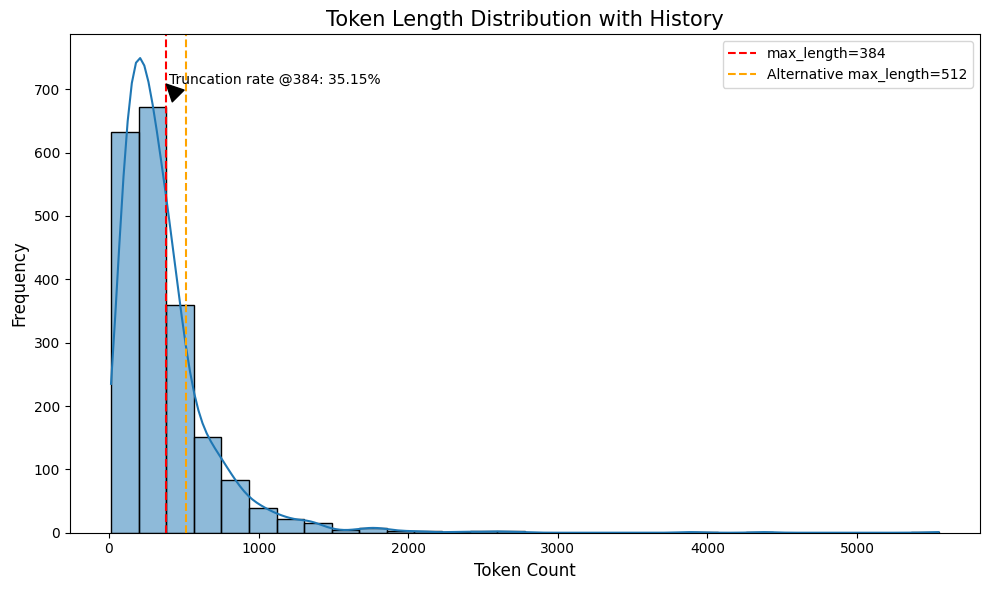

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(lens[:2000], bins=30, kde=True)
plt.axvline(x=384, color='red', linestyle='--', label=f'max_length={MAX_LEN}')
plt.axvline(x=512, color='orange', linestyle='--', label='Alternative max_length=512')
plt.title('Token Length Distribution with History', fontsize=15)
plt.xlabel('Token Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.annotate(f'Truncation rate @{MAX_LEN}: {np.mean(np.array(lens) > MAX_LEN):.2%}', 
             xy=(384, plt.ylim()[1]*0.9), xytext=(384+20, plt.ylim()[1]*0.9),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.tight_layout()
plt.show()

Model loader with optional LoRA 

In [20]:
num_labels = len(le_cat.classes_)

USE_LORA = False   #Not using at this stage

base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

if USE_LORA:
    from peft import LoraConfig, get_peft_model, TaskType

    if "roberta" in MODEL_NAME.lower():
        target_modules = ["query","key","value","dense"]
    elif "deberta" in MODEL_NAME.lower():
        target_modules = ["query_proj","key_proj","value_proj","o_proj"]
    else:
        target_modules = ["query","key","value","dense"]

    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.1,
        target_modules=target_modules
    )
    model = get_peft_model(base_model, lora_cfg)
    model.print_trainable_parameters()
else:
    model = base_model

model.gradient_checkpointing_enable()
model.config.use_cache = False  


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Helper Methods and Weighted sampler class with label smoothing 

In [21]:
print("Transformers:", transformers.__version__)
acc_metric = evaluate.load("accuracy")

# Class weights (inverse freq on the training split)
counts = np.bincount(y_tr)
class_weights = (counts.sum() / np.maximum(counts, 1)).astype(np.float32)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": float((preds == labels).mean()),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, freeze_encoder_epochs=1, label_smoothing=0.05, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32) if class_weights is not None else None
        self.freeze_encoder_epochs = freeze_encoder_epochs
        self.label_smoothing = label_smoothing
        self._frozen = False

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None,
            label_smoothing=self.label_smoothing
        )
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def get_train_dataloader(self):
        if self.train_dataset is None:
            return None
        labels = np.array(self.train_dataset["labels"])
        inv_freq = {c: (len(labels) / (np.sum(labels==c)+1e-9)) for c in np.unique(labels)}
        w = np.array([inv_freq[int(c)] for c in labels], dtype=np.float32)
        sampler = WeightedRandomSampler(weights=torch.from_numpy(w), num_samples=len(w), replacement=True)
        return DataLoader(self.train_dataset, batch_size=self.args.train_batch_size,
                          sampler=sampler, collate_fn=self.data_collator, num_workers=0)

    def _maybe_freeze(self):
        if not self._frozen:
            for n, p in self.model.named_parameters():
                if "classifier" in n:
                    p.requires_grad = True
                else:
                    p.requires_grad = False
            self._frozen = True

    def _unfreeze(self):
        for p in self.model.parameters():
            p.requires_grad = True

    def training_step(self, *args, **kwargs):
        if self.state.epoch is not None and self.state.epoch < self.freeze_encoder_epochs:
            self._maybe_freeze()
        else:
            self._unfreeze()
        return super().training_step(*args, **kwargs)

def make_args():
    try:
        return TrainingArguments(
            output_dir=f"artifacts/{MODEL_NAME.replace('/','_')}",
            per_device_train_batch_size=8,          
            per_device_eval_batch_size=16,
            gradient_accumulation_steps=2,
            num_train_epochs=8,                      
            learning_rate=3e-5,
            weight_decay=0.01,
            warmup_ratio=0.1,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True,
            fp16=False,                               
            report_to="none",
            bf16=True,
            logging_steps=50,
            remove_unused_columns=False,
        )
    except TypeError:
        return TrainingArguments(
            output_dir=f"artifacts/{MODEL_NAME.replace('/','_')}",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            gradient_accumulation_steps=2,
            save_strategy="epoch",
            num_train_epochs=8,
            learning_rate=3e-5,
            weight_decay=0.01,
            logging_steps=50,
            remove_unused_columns=False,
            dataloader_num_workers=0,
            bf16=True,
        )

args = make_args()

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["valid"],
    tokenizer=tok,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    freeze_encoder_epochs=1,    
    label_smoothing=0.1,
)
trainer.args = args
trainer.callback_handler.callbacks = [
    EarlyStoppingCallback(early_stopping_patience=2)  
]

if hasattr(torch, "xpu") and torch.xpu.is_available():
    model.to("xpu")
    trainer._move_model_to_device = lambda m, d: None
    print("Using Intel Arc (XPU)")
else:
    print("XPU not available; using CPU")


Transformers: 4.49.0


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\gupta\AppData\Local\Temp\ipykernel_9804\239435769.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Using Intel Arc (XPU)


 Train and evaluate 

In [ ]:
train_out = trainer.train()
eval_out  = trainer.evaluate()
eval_out

C:\Users\gupta\AppData\Local\Temp\ipykernel_7792\897921707.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(self.train_dataset["labels"])
c:\Users\gupta\.conda\envs\TExtmining\Lib\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


{'eval_loss': 1.1458336114883423,
 'eval_accuracy': 0.8079847908745247,
 'eval_macro_f1': 0.5941386938679966,
 'eval_runtime': 38.3509,
 'eval_samples_per_second': 27.431,
 'eval_steps_per_second': 1.721,
 'epoch': 8.0}

In [ ]:
y_true = preds.label_ids
y_hat  = preds.predictions.argmax(axis=-1)
print(classification_report(y_true, y_hat, target_names=le_cat.classes_))
print(confusion_matrix(y_true, y_hat))


              precision    recall  f1-score   support

       S1000       0.59      0.38      0.46        58
     S1000v3       0.50      0.38      0.43       154
     S1000v4       0.86      0.92      0.89       840

    accuracy                           0.81      1052
   macro avg       0.65      0.56      0.59      1052
weighted avg       0.79      0.81      0.80      1052

[[ 22   1  35]
 [  2  59  93]
 [ 13  58 769]]


Token length diagnostics

In [ ]:
# fraction that gets truncated at MAX_LEN
tok_diag = AutoTokenizer.from_pretrained(MODEL_NAME)
lens = [len(tok_diag(x, truncation=False)["input_ids"]) for x in X_tr[:2000]]
print("Token len p95/p99:", np.percentile(lens, [95,99]))
print("Frac >384:", np.mean(np.array(lens) > 384), " | Frac >512:", np.mean(np.array(lens) > 512))


Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


Token len p95/p99: [293.   514.01]
Frac >384: 0.022  | Frac >512: 0.011


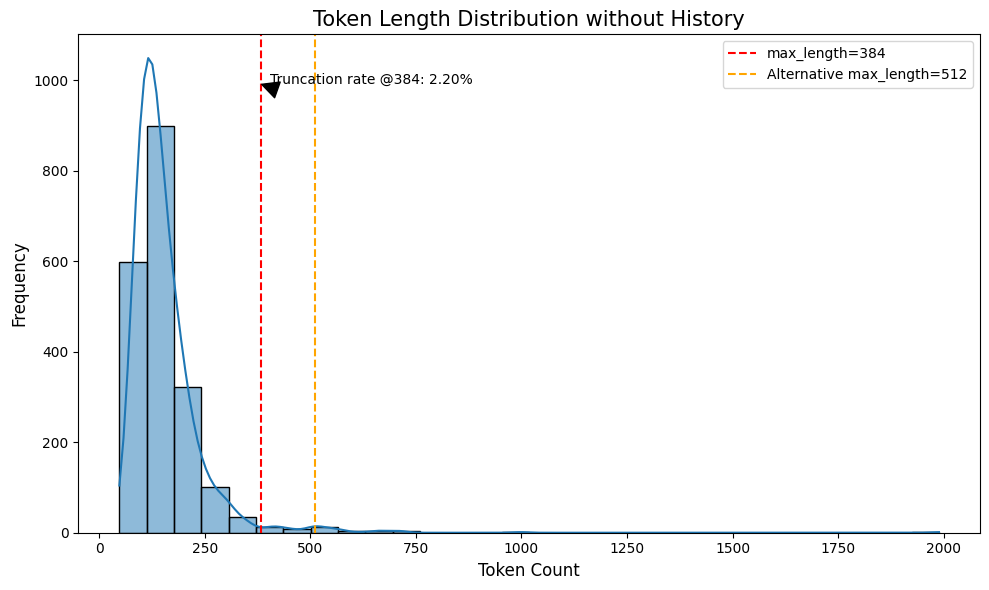

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(lens[:2000], bins=30, kde=True)
plt.axvline(x=384, color='red', linestyle='--', label=f'max_length={MAX_LEN}')
plt.axvline(x=512, color='orange', linestyle='--', label='Alternative max_length=512')
plt.title('Token Length Distribution without History', fontsize=15)
plt.xlabel('Token Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.annotate(f'Truncation rate @{MAX_LEN}: {np.mean(np.array(lens) > MAX_LEN):.2%}', 
             xy=(384, plt.ylim()[1]*0.9), xytext=(384+20, plt.ylim()[1]*0.9),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.tight_layout()
plt.show()

# PHASE 2 - Use the saved classifier to find top-n tickets and generate summary on top ticket

 Load the fine-tuned classifier on CPU

In [13]:
# latest checkpoint
CKPT_DIR = Path("artifacts/roberta-base/best")

tok   = AutoTokenizer.from_pretrained(CKPT_DIR)
model = AutoModelForSequenceClassification.from_pretrained(CKPT_DIR, torch_dtype=torch.float32).to("cpu").eval()

label_names = ["S1000", "S1000v3", "S1000v4"]  
i_s1k = label_names.index("S1000")
i_v3  = label_names.index("S1000v3")
i_v4  = label_names.index("S1000v4")

print("Loaded:", CKPT_DIR, " num_labels:", model.config.num_labels)


Loaded: artifacts\roberta-base\best  num_labels: 3


Tokenize only the validation split 

In [14]:
def tok_batch(texts, max_len=384):
    return tok(texts, truncation=True, max_length=max_len, padding=True, return_tensors="pt")

enc_val = tok_batch(X_va, max_len=384)
enc_val["labels"] = torch.tensor(y_va, dtype=torch.long)

class SimpleHFDataset(Dataset):
    def __init__(self, enc): self.enc = enc
    def __len__(self): return self.enc["input_ids"].shape[0]
    def __getitem__(self, i): return {k: v[i] for k,v in self.enc.items()}

val_ds = SimpleHFDataset(enc_val)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
len(val_ds)


1055

 CPU inference to get logits on the validation set for prabability 

In [8]:
model.eval().to("cpu")

all_logits, all_labels = [], []
with torch.no_grad():
    for batch in val_dl:
        labels = batch.pop("labels").numpy()
        outputs = model(**{k: v for k,v in batch.items()})
        all_logits.append(outputs.logits.numpy())
        all_labels.append(labels)

logits = np.concatenate(all_logits, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# Softmax
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
probs.shape, y_true.shape


((1055, 3), (1055,))

v4 class threshold sweep to maximize macro-F1 


In [15]:
def predict_with_v4_threshold(probs, thr):
    y_hat = []
    for p in probs:
        if p[i_v4] >= thr:
            y_hat.append(i_v4)
        else:
            y_hat.append(i_s1k if p[i_s1k] >= p[i_v3] else i_v3)
    return np.array(y_hat)

# Sweeping 1000 evenly-spaced thresholds from 0.0 to 0.999
ths = np.linspace(0.0, 0.999, 1000)
f1_scores = []
best_thr, best_f1, best_rep = None, -1, None
best_y_hat = None

for t in ths:
    y_hat = predict_with_v4_threshold(probs, t)
    mf1 = f1_score(y_true, y_hat, average="macro")
    f1_scores.append(mf1)
    if mf1 > best_f1:
        best_thr, best_f1 = float(t), float(mf1)
        best_rep = classification_report(y_true, y_hat, target_names=label_names, digits=3)
        best_y_hat = y_hat

print(f"Best v4 threshold: {best_thr:.3f}  → Macro-F1 {best_f1:.4f}")
print(best_rep)

V4_BEST_THR = best_thr

c:\Users\gupta\.conda\envs\TExtmining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gupta\.conda\envs\TExtmining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gupta\.conda\envs\TExtmining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Best v4 threshold: 0.006  → Macro-F1 0.6945
              precision    recall  f1-score   support

       S1000      0.787     0.627     0.698        59
     S1000v3      0.663     0.370     0.475       154
     S1000v4      0.871     0.954     0.910       842

    accuracy                          0.850      1055
   macro avg      0.774     0.650     0.695      1055
weighted avg      0.836     0.850     0.835      1055



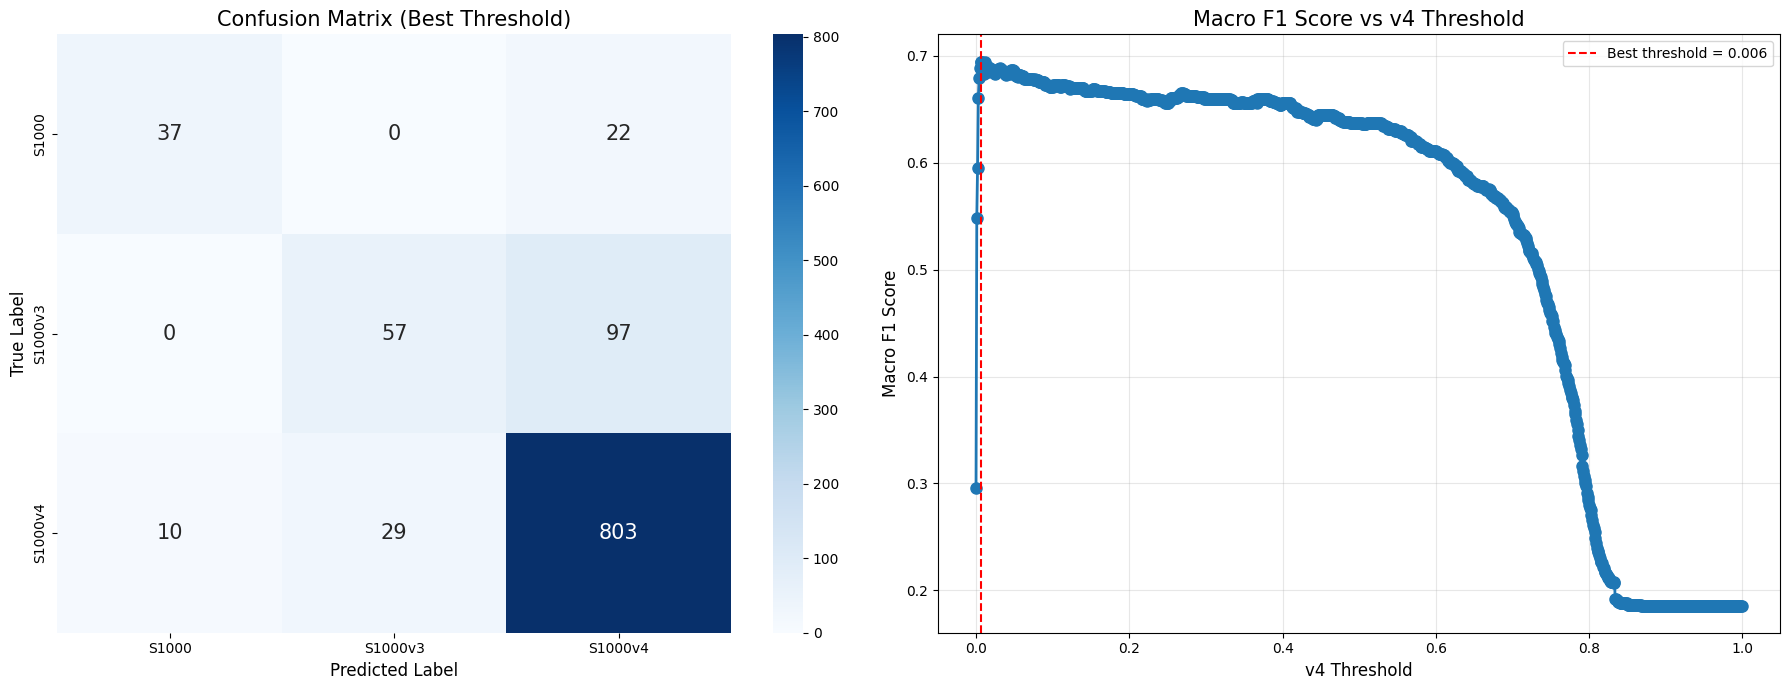

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1 - Confusion Matrix
cm = confusion_matrix(y_true, best_y_hat)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    ax=axes[0],
    annot_kws={'fontsize': 15}
)
axes[0].set_title('Confusion Matrix (Best Threshold)', fontsize=15)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Plot 2 - F1 Score vs Threshold
axes[1].plot(ths, f1_scores, 'o-', linewidth=2, markersize=8)
axes[1].axvline(x=best_thr, color='red', linestyle='--', 
            label=f'Best threshold = {best_thr:.3f}')
axes[1].set_xlabel('v4 Threshold', fontsize=12)
axes[1].set_ylabel('Macro F1 Score', fontsize=12)
axes[1].set_title('Macro F1 Score vs v4 Threshold', fontsize=15)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

### classifier inference 

In [9]:
model.eval()
_device = next(model.parameters()).device  # picking xpu for local system

def _coerce_to_str_list(texts):
    if isinstance(texts, str):
        return [texts], True  
    if isinstance(texts, pd.Series):
        return texts.fillna("").astype(str).tolist(), False
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, (list, tuple)):
        out = []
        for t in texts:
            if t is None:
                out.append("")
            elif isinstance(t, float) and np.isnan(t):
                out.append("")
            else:
                out.append(str(t))
        return out, False
    return ["" if texts is None else str(texts)], True

def predict_label_probs(texts, max_len=384):
    batch, single = _coerce_to_str_list(texts)

    enc = tok(
        batch,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    )
    enc = {k: v.to(_device) for k, v in enc.items()}

    with torch.no_grad():
        logits = model(**enc).logits  
        probs  = torch.softmax(logits, dim=-1).detach().cpu().numpy()

    return probs[0] if single else probs

def safe_predict_label_probs(texts):
    arr = predict_label_probs(texts)
    return np.atleast_2d(arr).astype("float32", copy=False)


MPNet + rebuild FAISS with Embeddings with history-lite + cached FAISS --- Build TEXT_FULL 

In [ ]:

ART = Path("artifacts")
ART.mkdir(parents=True, exist_ok=True)

EMB_MODEL_NAME = "sentence-transformers/paraphrase-mpnet-base-v2"
EMB_SAVE_DIR   = ART / "emb_model"           # local copy of the SentenceTransformer
INDEX_PATH     = ART / "faiss_index.bin"     # FAISS index
DOCS_PATH      = ART / "docs_df.pkl"         # cached DOCS_DF 
META_PATH      = ART / "emb_meta.json"       # version/validation metadata

FORCE_REBUILD  = False

RESOLUTION_VERBS = r"\b(fix|resolve|change|set|enable|disable|update|restart|reindex|rebuild|reconfigure|grant|add|remove|adjust|correct|apply|patch|upgrade|install|uninstall|rollback|truncate|refresh|recreate|clear|delete|rerun|repost|reconcile|authori[sz]e)\w*"
RESOLUTION_RX = re.compile(RESOLUTION_VERBS, re.I)

DISCARD_PATTERNS = [
    r"^kind regards|^best regards|^thanks\b|^thank you\b|^regards\b",
    r"^please see attached|^see attachment|^as discussed\b",
    r"^this email.*confidential|^it is intended only.*addressee",
    r"^hi\b|^hello\b|^dear\b",
    r"unsubscribe|privacy notice|gdpr",
    r"^\s*(nan|none)\s*$",
]
DISCARD_RX = [re.compile(p, re.I) for p in DISCARD_PATTERNS]

def _split_sents(text: str):
    if not isinstance(text, str) or not text:
        return []
    parts = re.split(r"(?<=[.!?])\s+|[\r\n]+", text)
    return [p.strip() for p in parts if p and p.strip()]

def _looks_actionable(s: str) -> bool:
    return bool(RESOLUTION_RX.search(s))

def _filter_junk(lines):
    out = []
    for ln in lines:
        if any(rx.search(ln) for rx in DISCARD_RX):
            continue
        out.append(ln)
    return out

def build_text_full_actionable(df: pd.DataFrame, max_hist_lines: int = 8) -> pd.Series:
    for c in ["SUBJECT","PROBLEM","SOLUTION","HISTORY_TEXT"]:
        if c not in df: df[c] = ""
    subj = df["SUBJECT"].fillna("").astype(str)
    prob = df["PROBLEM"].fillna("").astype(str)
    sol  = df["SOLUTION"].fillna("").astype(str)
    hist = df["HISTORY_TEXT"].fillna("").astype(str)

    hist_sel = []
    for h in hist:
        lines = _split_sents(h)
        act   = [ln for ln in lines if _looks_actionable(ln)]
        hist_sel.append(_filter_junk(act[-max_hist_lines:]))

    out = []
    for s, p, so, hs in zip(subj, prob, sol, hist_sel):
        base = f"[SUBJECT] {s} [PROBLEM] {p} [SOLUTION] {so}".strip()
        if hs:
            hist_txt = " ".join(hs)
            full = f"{base} [HISTORY_ACTIONS] {hist_txt}"
        else:
            full = base
        out.append(full)
    return pd.Series(out, index=df.index)

def md5_list(values) -> str:
    m = hashlib.md5()
    for v in values:
        m.update(str(v).encode("utf-8", errors="ignore"))
        m.update(b"\x00")
    return m.hexdigest()

def make_meta(model_name: str, df: pd.DataFrame, vec_dim: int) -> dict:
    return {
        "model_name": model_name,
        "num_docs":   int(len(df)),
        "vec_dim":    int(vec_dim),
        "ticket_ids_hash": md5_list(df["TICKETID"].astype(str).tolist()),
        "text_full_hash":  md5_list(df["TEXT_FULL"].astype(str).tolist()),
        "created_utc": datetime.now(timezone.utc).isoformat(timespec="seconds"),
    }

def meta_equal(current: dict, cached: dict) -> bool:
    keys = ["model_name","num_docs","vec_dim","ticket_ids_hash","text_full_hash"]
    return all(str(current.get(k)) == str(cached.get(k)) for k in keys)

DOCS_DF = tickets.copy()
DOCS_DF["TICKETID"] = DOCS_DF["TICKETID"].astype(str)

DOCS_DF["TEXT_FULL"] = build_text_full_actionable(DOCS_DF, max_hist_lines=8)

num_with_hist = int((DOCS_DF["TEXT_FULL"].str.contains(r"\[HISTORY_ACTIONS\]")).sum())
print(f" TEXT_FULL built. Rows with actionable history appended: {num_with_hist}/{len(DOCS_DF)}")

current_meta_stub = {
    "model_name": EMB_MODEL_NAME,
    "num_docs":   int(len(DOCS_DF)),
    "ticket_ids_hash": md5_list(DOCS_DF["TICKETID"].tolist()),
    "text_full_hash":  md5_list(DOCS_DF["TEXT_FULL"].tolist()),
}

# Trying to load cached artifacts and validate 
loaded_ok = False
if not FORCE_REBUILD and INDEX_PATH.exists() and DOCS_PATH.exists() and META_PATH.exists() and EMB_SAVE_DIR.exists():
    try:
        print("Attempting to load cached FAISS + DOCS_DF + emb_model + meta…")
        index   = faiss.read_index(str(INDEX_PATH))
        cached  = pd.read_pickle(DOCS_PATH)
        emb_model = SentenceTransformer(str(EMB_SAVE_DIR))
        meta    = json.load(open(META_PATH, "r"))

        assert {"TICKETID","TEXT_FULL","CATEGORY_NORM"}.issubset(set(cached.columns)), \
            "DOCS_DF cache missing required columns"
        assert index.ntotal == len(cached), f"Index rows ({index.ntotal}) != DOCS_DF rows ({len(cached)})"

        current_meta = dict(current_meta_stub)
        current_meta["vec_dim"] = int(index.d)

        if meta_equal(current_meta, meta):
            if (
                len(DOCS_DF) == len(cached)
                and md5_list(DOCS_DF["TICKETID"].tolist()) == meta["ticket_ids_hash"]
                and md5_list(DOCS_DF["TEXT_FULL"].tolist()) == meta["text_full_hash"]
            ):
                DOCS_DF = cached
                print(f"Loaded cache vectors: {index.ntotal}  dim: {index.d}  model: {meta['model_name']}")
                loaded_ok = True
            else:
                print("Cache DOCS_DF hash/length mismatch with current tickets - rebuild.")
        else:
            print("Cache meta mismatch (model/num_docs/hashes) -rebuild.")
    except Exception as e:
        print(f" Cache load failed: {e}\n-Will rebuild.")

# Rebuilding the embeddings if needed 
if not loaded_ok:
    print(" Building embeddings + FAISS index from scratch")
    # Ensure embedding model present 
    if EMB_SAVE_DIR.exists() and not FORCE_REBUILD:
        try:
            emb_model = SentenceTransformer(str(EMB_SAVE_DIR))
            print("Loaded existing emb_model from artifacts/emb_model")
        except Exception:
            emb_model = SentenceTransformer(EMB_MODEL_NAME)
            emb_model.save_pretrained(str(EMB_SAVE_DIR))
            print("Re-saved emb_model to artifacts/emb_model")
    else:
        emb_model = SentenceTransformer(EMB_MODEL_NAME)
        emb_model.save_pretrained(str(EMB_SAVE_DIR))
        print("Downloaded & saved emb_model:", EMB_MODEL_NAME)

    # Encode (normalize -cosine via inner product)
    all_vecs = emb_model.encode(
        DOCS_DF["TEXT_FULL"].tolist(),
        batch_size=128,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    d = all_vecs.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(all_vecs.astype(np.float32))

    # saving cache
    DOCS_DF.to_pickle(DOCS_PATH)
    faiss.write_index(index, str(INDEX_PATH))
    meta = make_meta(EMB_MODEL_NAME, DOCS_DF, vec_dim=d)
    with open(META_PATH, "w") as f:
        json.dump(meta, f, indent=2)
    print(f"Built & saved vectors: {index.ntotal}  dim: {d}  model: {EMB_MODEL_NAME}")

DOC_META = DOCS_DF[["TICKETID","CATEGORY_NORM","SUBJECT","SOLUTION"]].reset_index(drop=True)

assert index.ntotal == len(DOCS_DF), "Index and DOCS_DF are misaligned."
gc.collect();


 TEXT_FULL built. Rows with actionable history appended: 2218/5275
Attempting to load cached FAISS + DOCS_DF + emb_model + meta…
Cache meta mismatch (model/num_docs/hashes) -rebuild.
 Building embeddings + FAISS index from scratch
Loaded existing emb_model from artifacts/emb_model


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Built & saved vectors: 5275  dim: 768  model: sentence-transformers/paraphrase-mpnet-base-v2


Cross-encoder re-ranker

In [10]:
RERANK_MODEL = "cross-encoder/ms-marco-MiniLM-L-6-v2"
reranker = CrossEncoder(RERANK_MODEL)  

README.md: 0.00B [00:00, ?B/s]

confidence-aware retrieve_with_rerank 

In [39]:
test_vec = safe_predict_label_probs(DOCS_DF["TEXT_FULL"].iloc[:2])
print("safe probs shape:", test_vec.shape)  


safe probs shape: (2, 3)


Summarizer-helpers - doc gating + candidate cleaning + deduplication

In [ ]:
def select_docs_by_threshold(ret_top: list, rel_key="score", max_docs=1, rel_frac=0.85):
    # Keep only documents whose reranker score >= rel_frac * best_score
    if not ret_top:
        return []
    best = max(r.get(rel_key, 0.0) for r in ret_top)
    kept = [r for r in ret_top if r.get(rel_key, 0.0) >= rel_frac * best]
    kept = sorted(kept, key=lambda r: r.get(rel_key, 0.0), reverse=True)[:max_docs]
    return kept

def sentence_embed(lines: list) -> np.ndarray:
    if not lines:
        return np.zeros((0, emb_model.get_sentence_embedding_dimension()), dtype="float32")
    vecs = emb_model.encode(lines, convert_to_numpy=True, normalize_embeddings=True)
    return vecs.astype("float32", copy=False)

def dedupe_by_cosine(lines: list, thresh=0.85) -> list:
    # Remove near-duplicates using cosine similarity on embeddings
    if not lines:
        return []
    vecs = sentence_embed(lines)
    keep, kept_vecs = [], []
    for i, s in enumerate(lines):
        v = vecs[i]
        if kept_vecs:
            sims = np.dot(np.vstack(kept_vecs), v)
            if np.max(sims) >= thresh:
                continue
        keep.append(s)
        kept_vecs.append(v)
    return keep


Category-gated retrieval with dual cross-encoder re-rank (down-weight history) 

In [11]:
ce = reranker

def _split_core_hist(doc_text: str):
    # Split TEXT_FULL into (core, history) 
    if not isinstance(doc_text, str):
        return "", ""
    # Everything before the tag is 'core', after is 'history'
    if "[HISTORY_ACTIONS]" in doc_text:
        core, hist = doc_text.split("[HISTORY_ACTIONS]", 1)
    else:
        core, hist = doc_text, ""
    core = core.replace("[SUBJECT]", "").replace("[PROBLEM]", "").replace("[SOLUTION]", "").strip()
    hist = hist.strip()
    return core, hist

def _ce_dual_score(query: str, docs: list[str], alpha: float = 0.2, batch_size: int = 32):
    # Return blended CE score per doc: score = CE(query, core) + alpha * CE(query, hist) 
    core_texts, hist_texts = [], []
    for t in docs:
        c, h = _split_core_hist(t)
        core_texts.append(c if c else t)
        hist_texts.append(h)

    pairs_core = [[query, c] for c in core_texts]
    scores_core = ce.predict(pairs_core, batch_size=batch_size)

    # Only compute history pass for docs that actually have history text
    scores_hist = np.zeros_like(scores_core, dtype=float)
    idx_hist = [i for i, h in enumerate(hist_texts) if h]
    if idx_hist:
        pairs_hist = [[query, hist_texts[i]] for i in idx_hist]
        scores_hist_sel = ce.predict(pairs_hist, batch_size=batch_size)
        for j, i in enumerate(idx_hist):
            scores_hist[i] = scores_hist_sel[j]

    return scores_core + alpha * scores_hist

def retrieve_with_rerank_conf(
    query_text: str,
    topn: int = 20,
    topk: int = 5,
    tau: float = 0.55,
    delta: float = 0.07,
    exclude_ticket_id: str | None = None,
    debug: bool = False,
):
    # category gate
    probs = predict_label_probs([query_text])[0]     
    order = np.argsort(-probs)
    p1, c1 = float(probs[order[0]]), int(order[0])
    p2, c2 = float(probs[order[1]]), int(order[1]) if len(order) > 1 else (0.0, None)
    cats_to_use = [c1]
    if (p1 - p2) < delta and p2 is not None and p2 > tau:
        cats_to_use.append(c2)
    pred_label = le_cat.classes_[c1]

    # FAISS ANN 
    qv = emb_model.encode([query_text], convert_to_numpy=True, normalize_embeddings=True)
    D, I = index.search(qv.astype(np.float32), topn)
    cand_idx = I[0].tolist()

    if exclude_ticket_id is not None:
        excl = str(exclude_ticket_id)
        cand_idx = [i for i in cand_idx if str(DOC_META["TICKETID"].iloc[i]) != excl]

    cand_idx = [i for i in cand_idx if le_cat.transform([DOC_META["CATEGORY_NORM"].iloc[i]])[0] in cats_to_use]

    if not cand_idx:
        return {"pred_label": pred_label, "top": []}

    # Dual CE re-rank
    docs_text = DOCS_DF["TEXT_FULL"].iloc[cand_idx].tolist()
    ce_scores = _ce_dual_score(query_text, docs_text, alpha=0.2, batch_size=32)

    # Blend with FAISS cosine 
    cos = D[0][:len(cand_idx)]
    final = 0.85 * ce_scores + 0.15 * cos

    order2 = np.argsort(-final)[:topk]
    top = []
    for pos in order2:
        i = cand_idx[pos]
        row = DOC_META.iloc[i]
        top.append({
            "ticket_id": str(row["TICKETID"]),
            "category": row["CATEGORY_NORM"],
            "subject": str(row["SUBJECT"])[:200],
            "solution": str(row["SOLUTION"])[:800],
            "score": float(final[pos]),
            "idx": int(i),
        })

    if debug:
        print("DEBUG subjects:", [t["subject"] for t in top])

    return {"pred_label": pred_label, "top": top}

retrieve_with_rerank = retrieve_with_rerank_conf


per-class P@5 (balanced) using confidence-aware gate

In [ ]:
def balanced_indices(df: pd.DataFrame, label_col="CATEGORY_NORM", per_class=100, seed=42):
    # Return indices where each class contributes up to per_class examples without replacement 
    rng = np.random.default_rng(seed)
    classes = sorted(df[label_col].dropna().unique().tolist())
    idxs = []
    for c in classes:
        pool = df.index[df[label_col] == c].to_numpy()
        take = min(per_class, len(pool))
        if take > 0:
            idxs.extend(rng.choice(pool, size=take, replace=False).tolist())
    rng.shuffle(idxs)
    return idxs, classes


In [44]:
# per-class P@5 (balanced) using confidence-aware gate

def eval_predgate_balanced_conf(per_class=100, topn=30, topk=5, tau=0.55, delta=0.07, seed=42):
    idxs, classes = balanced_indices(DOCS_DF, "CATEGORY_NORM", per_class=per_class, seed=seed)
    cls_to_ps = {c: [] for c in classes}
    for i in tqdm(idxs, total=len(idxs)):
        qtext   = DOCS_DF["TEXT_FULL"].iloc[i]
        truecat = DOCS_DF["CATEGORY_NORM"].iloc[i]
        ret     = retrieve_with_rerank_conf(qtext, topn=topn, topk=topk, tau=tau, delta=delta)
        cats    = [r["category"] for r in ret["top"]]
        p       = (sum(1 for c in cats if c == truecat) / len(cats)) if cats else 0.0
        cls_to_ps[truecat].append(p)
    per_cls = {c: float(np.mean(v)) if v else 0.0 for c, v in cls_to_ps.items()}
    macro_p = float(np.mean(list(per_cls.values()))) if per_cls else 0.0
    return macro_p, per_cls

In [45]:
macro_p, per_cls = eval_predgate_balanced_conf(per_class=100, topn=30, topk=5, tau=0.55, delta=0.07)
print("[Balanced conf] Macro P@5:", f"{macro_p*100:.2f}%")
for c, v in per_cls.items():
    print(f"  {c:8s}  P@5={v*100:.2f}%")


100%|██████████| 300/300 [03:11<00:00,  1.56it/s]

[Balanced conf] Macro P@5: 85.00%
  S1000     P@5=84.00%
  S1000v3   P@5=86.00%
  S1000v4   P@5=85.00%


Sweep for tau and delta values

In [ ]:
candidates = [(t, d) for t in (0.50, 0.55, 0.60) for d in (0.07, 0.10, 0.15)]
best = None
for (t, d) in candidates:
    m, _ = eval_predgate_balanced_conf(per_class=80, topn=20, topk=5, tau=t, delta=d)
    print(f"tau={t:.2f}  delta={d:.2f}  → Macro P@5={m*100:.2f}%")
    if best is None or m > best[0]:
        best = (m, t, d)
print("Best on this grid:", best)


In [47]:
SUMM_MAX_POINTS    = 7     
CE_HIST_ALPHA      = 0.20  
RERANK_TOPN        = 30    
TAU, DELTA         = 0.55, 0.07  


same-category retrieval WITHOUT classifier gate ( but WITH re-ranker)

In [48]:
def retrieve_with_rerank_no_classifier(query_text, known_category=None, topn=30, topk=5, batch_size=64):
    # ANN
    qv = emb_model.encode([query_text], convert_to_numpy=True, normalize_embeddings=True)
    D, I = index.search(qv.astype(np.float32), topn)
    cand_idx = I[0].tolist()

    # Re-rank the ANN candidates with cross-encoder
    pairs  = [[query_text, DOCS_DF["TEXT_FULL"].iloc[i]] for i in cand_idx]
    scores = reranker.predict(pairs, batch_size=batch_size, show_progress_bar=False)
    ranked = sorted(zip(cand_idx, scores), key=lambda x: x[1], reverse=True)

    # Strict same-category filter if provided
    if known_category is not None:
        ranked = [(i, s) for i, s in ranked if DOC_META["CATEGORY_NORM"].iloc[i] == known_category]

    ranked = ranked[:topk]
    results = []
    for i, s in ranked:
        row = DOC_META.iloc[i]
        results.append({
            "ticket_id": str(row["TICKETID"]),
            "category": row["CATEGORY_NORM"],
            "subject": str(row["SUBJECT"])[:200],
            "solution": str(row["SOLUTION"])[:600],
            "score": float(s),
            "idx": int(i),
        })
    return results


Pred-gate (real distribution) 

In [ ]:
def eval_retrieval_predgate_real(n_eval=300, topn=30, topk=5, seed=42):
    rng = np.random.default_rng(seed)
    sample = rng.choice(len(DOCS_DF), size=min(n_eval, len(DOCS_DF)), replace=False)
    precisions, hits = [], []
    for i in tqdm(sample, total=len(sample)):
        qtext   = DOCS_DF["TEXT_FULL"].iloc[i]
        truecat = DOCS_DF["CATEGORY_NORM"].iloc[i]
        ret     = retrieve_with_rerank(qtext, topn=topn, topk=topk)  
        cats    = [r["category"] for r in ret["top"]]
        same    = [1 if c == truecat else 0 for c in cats]
        precisions.append(sum(same)/len(cats) if cats else 0.0)
        hits.append(int(sum(same) > 0))
    return float(np.mean(precisions)), float(np.mean(hits))

P5_real, H5_real = eval_retrieval_predgate_real(n_eval=300, topn=30, topk=5)
print(f"[Pred-gate REAL] P@5: {P5_real*100:.2f}%   Hit@5: {H5_real*100:.2f}%   (topn=30, re-ranked)")


100%|██████████| 300/300 [02:50<00:00,  1.76it/s]

[Pred-gate REAL] P@5: 87.00%   Hit@5: 87.00%   (topn=20, re-ranked)


Pred-gate (balanced) 

In [ ]:
def eval_retrieval_predgate_balanced(per_class=100, topn=30, topk=5, seed=42):
    idxs, classes = balanced_indices(DOCS_DF, "CATEGORY_NORM", per_class=per_class, seed=seed)
    precisions, hits = [], []
    for i in tqdm(idxs, total=len(idxs)):
        qtext   = DOCS_DF["TEXT_FULL"].iloc[i]
        truecat = DOCS_DF["CATEGORY_NORM"].iloc[i]
        ret     = retrieve_with_rerank(qtext, topn=topn, topk=topk)  
        cats    = [r["category"] for r in ret["top"]]
        same    = [1 if c == truecat else 0 for c in cats]
        precisions.append(sum(same)/len(cats) if cats else 0.0)
        hits.append(int(sum(same) > 0))
    return float(np.mean(precisions)), float(np.mean(hits))

P5_bal, H5_bal = eval_retrieval_predgate_balanced(per_class=100, topn=30, topk=5)
print(f"[Pred-gate BALANCED] P@5: {P5_bal*100:.2f}%   Hit@5: {H5_bal*100:.2f}%   (topn=30, re-ranked)")


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [04:05<00:00,  1.22it/s]

[Pred-gate BALANCED] P@5: 85.00%   Hit@5: 85.00%   (topn=30, re-ranked)


 GT-gate (balanced) for ceiling values

In [ ]:
def eval_retrieval_groundtruth_balanced(per_class=100, topn=30, topk=5, seed=42):
    idxs, classes = balanced_indices(DOCS_DF, "CATEGORY_NORM", per_class=per_class, seed=seed)
    precisions, hits = [], []
    for i in tqdm(idxs, total=len(idxs)):
        qtext   = DOCS_DF["TEXT_FULL"].iloc[i]
        truecat = DOCS_DF["CATEGORY_NORM"].iloc[i]
        top     = retrieve_with_rerank_no_classifier(qtext, known_category=truecat, topn=topn, topk=topk)
        cats    = [r["category"] for r in top]
        same    = [1 if c == truecat else 0 for c in cats]
        precisions.append(sum(same)/len(cats) if cats else 0.0)
        hits.append(int(sum(same) > 0))
    return float(np.mean(precisions)), float(np.mean(hits))

P5_gt, H5_gt = eval_retrieval_groundtruth_balanced(per_class=100, topn=30, topk=5)
print(f"[GT-gate BALANCED] P@5: {P5_gt*100:.2f}%   Hit@5: {H5_gt*100:.2f}%   (upper bound)")


100%|██████████| 300/300 [15:48<00:00,  3.16s/it]   

[GT-gate BALANCED] P@5: 100.00%   Hit@5: 100.00%   (upper bound)


PII-safe light RAG summary 

In [ ]:
RE_EMAIL  = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
RE_PHONE  = re.compile(r"\b(?:\+?\d[\d\-\s]{7,}\d)\b")
RE_BRACK  = re.compile(r"\[[A-Z_]{3,}\]")   # [REDACTED_NAME], [PHONE], …

def strip_pii_tokens(t: str) -> str:
    if not t: return t
    t = RE_EMAIL.sub("", t)
    t = RE_PHONE.sub("", t)
    t = RE_BRACK.sub("", t)
    t = re.sub(r"\s{2,}", " ", t).strip(" -–—")
    return t

# sentence splitting, timestamp & junk filters 
SENT_SPLIT = re.compile(r"(?<=[.!?])\s+|[\r\n]+")
LEAD_TS_RX = re.compile(r"^(?:\d{4}-\d{2}-\d{2}\s+)?\d{1,2}:\d{2}\s*[ -—-]\s*")  

JUNK_RX = [
    re.compile(r"^\s*(nan|none)\s*$", re.I),
    re.compile(r"\b(ticket received|status (has )?changed|email change of status)\b", re.I),
    re.compile(r"\b(confidentiality|disclaimer|virus|intended only for the addressee)\b", re.I),
    re.compile(r"^(hi|hello|dear)\b", re.I),
    re.compile(r"\b(kind regards|best regards|thanks|thank you)\b", re.I),
]
NEG_Q_RX   = re.compile(r"\?$")
BRACK_HEAVY = re.compile(r"(?:\[[^\]]+\].*){2,}")

def normalize_line(s: str) -> str:
    s = s or ""
    s = strip_pii_tokens(s)
    # drop leading timestamps
    s = LEAD_TS_RX.sub("", s)              
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

def split_sents(t: str) -> List[str]:
    if not isinstance(t, str) or not t: return []
    t = re.sub(r"\s+", " ", t.strip())
    parts = [normalize_line(p) for p in SENT_SPLIT.split(t)]
    return [p for p in parts if p]

def is_junk(s: str) -> bool:
    return any(rx.search(s) for rx in JUNK_RX) or NEG_Q_RX.search(s) is not None or BRACK_HEAVY.search(s) is not None

#  domain/action cues to recognise and train
IMP_START   = r"^(set|change|update|restart|reindex|rebuild|reconfigure|configure|install|uninstall|upgrade|patch|apply|enable|disable|clear|delete|truncate|refresh|rerun|repost|reconcile|authori[sz]e|allocate|assign|map|grant|revoke|reprint|release|fix)\b"
ACTION_RX   = re.compile(IMP_START, re.I)
ACTION_CUE  = re.compile(r"(set|change|update|restart|reindex|rebuild|install|uninstall|enable|disable|clear|apply|patch|rerun|repost|reconcile|authori[sz]e|allocate|assign|grant|revoke|reprint|release|fix|admin (rights|privileges)|java)", re.I)
DOMAIN_RX   = re.compile(r"(system key|version|service|registry|path|error|code|trace|log|bacs|dd1|trial\s*balance|spool|report|module|company|bank|posting|status|po|invoice|supplier|ledger|crm|sage|mtd|ocsp|certificate|encoding|£|ckworkqum|cbtranm|podetm)", re.I)

def looks_action(s: str) -> bool:
    if is_junk(s): return False
    wc = len(s.split())
    if wc < 4 or wc > 60: return False
    return bool(ACTION_RX.search(s) or (ACTION_CUE.search(s) and DOMAIN_RX.search(s)))

def looks_finding(s: str) -> bool:
    if is_junk(s): return False
    wc = len(s.split())
    if wc < 6 or wc > 70: return False
    if re.search(r"\b(please|could you|would you|can you)\b", s, re.I): return False
    return bool(DOMAIN_RX.search(s))

def trim_runon(s: str) -> str:
    s = re.split(r"\b(?:so|therefore|however|suspect|hence|Sally\b|I (?:can|will)|we (?:can|will))\b", s, maxsplit=1)[0]
    return re.sub(r"\s{2,}", " ", s).strip(" .,- -—")

# fact extraction with version collapse
KEY_RX      = re.compile(r"\b([A-Z]{3,}[A-Z0-9]{2,})\b")
SET_RX      = re.compile(r"\b(set|change|update)\b.*?\b(key|system key)\b.*?\b([A-Z]{3,}[A-Z0-9]{2,})\b.*?\b(to|=)\s*([A-Z0-9_]+)", re.I)
VERSION_RX  = re.compile(r"\b(v(?:ersion)?\s*[:=]?\s*(\d+(?:\.\d+){1,3})|\b(\d+(?:\.\d+){2,})\b)\b", re.I)
TABLE_RX    = re.compile(r"\b(ckworkqum|cbtranm|podetm)\b", re.I)
ACTION_VERB = re.compile(r"\b(set|change|update|restart|reindex|rebuild|install|uninstall|enable|disable|clear|apply|patch|rerun|repost|reconcile|authori[sz]e|reprint|release|fix)\b", re.I)

def parse_version(s: str) -> tuple:
    nums = [int(x) for x in s.split(".") if x.isdigit()]
    while len(nums) < 3: nums.append(0)
    return tuple(nums[:3])

def extract_facts(text: str) -> Dict[str, List[Dict]]:
    facts = {"set_keys": [], "versions": set(), "tables": set(), "key_refs": set()}
    t = strip_pii_tokens(text or "")
    for sent in split_sents(t):
        s = trim_runon(sent)
        if is_junk(s): continue
        m = SET_RX.search(s)
        if m:
            facts["set_keys"].append({"key": m.group(3), "value": m.group(5)})
        for vfull, v1, v2 in VERSION_RX.findall(s):
            v = v1 or v2
            if v: facts["versions"].add(v)
        for tb in TABLE_RX.findall(s):
            facts["tables"].add(tb)
        if ACTION_VERB.search(s):
            for k in KEY_RX.findall(s):
                facts["key_refs"].add(k)
    versions_sorted = sorted(list(facts["versions"]), key=parse_version, reverse=True)
    facts["versions"] = versions_sorted[:2]
    return facts

def steps_from_facts(facts: Dict) -> List[str]:
    out = []
    for kv in facts["set_keys"]:
        out.append(f"Set system key {kv['key']} to {kv['value']}.")
    if facts["versions"]:
        top = facts["versions"][0]
        out.append(f"Confirm the installed version; upgrade to {top} if the issue is fixed in that release.")
    for tb in facts["tables"]:
        out.append(f"Verify entries in table {tb} and re-run the process if incorrect.")
    for k in facts["key_refs"]:
        out.append(f"Review system key {k} and correct its value if misconfigured.")
    # dedupe
    seen = set(); dedup = []
    for s in out:
        k = s.lower()
        if k in seen: continue
        seen.add(k); dedup.append(s)
    return dedup

# hints if bullets are too few 
MTD_ADMIN_RX   = re.compile(r"\b(admin (rights|privileges)|full admin)\b", re.I)
MTD_ORDER_RX   = re.compile(r"\binstall (?:the )?(\d+ )?programs? in order|install order|uninstall all software and install.*in order\b", re.I)
MTD_LOG_RX     = re.compile(r"\bMTDFCE\.log\b", re.I)
MTD_JAVA_RX    = re.compile(r"\bjava settings?\b", re.I)

def mtd_hints_from_text(text: str) -> List[str]:
    t = (text or "")
    hints = []
    if MTD_ADMIN_RX.search(t): hints.append("Install the MTD client with full admin rights for the submitting user.")
    if MTD_ORDER_RX.search(t): hints.append("Follow the documented MTD install order; uninstall first, then install components in sequence.")
    if MTD_LOG_RX.search(t):   hints.append("If the submit button is missing, capture and review MTDFCE.log.")
    if MTD_JAVA_RX.search(t):  hints.append("Ensure Java client settings match the install guide on the affected PC.")
    # de-duplicate
    seen=set(); out=[]
    for h in hints:
        if h not in seen:
            out.append(h); seen.add(h)
    return out

try:
    summ_tok; summ_mod
except NameError:
    SUMM_MODEL = "google/flan-t5-base"
    summ_tok = AutoTokenizer.from_pretrained(SUMM_MODEL)
    summ_mod = AutoModelForSeq2SeqLM.from_pretrained(SUMM_MODEL)

def gen_step(sent: str, max_new_tokens=72) -> str:
    prompt = (
        "Rewrite as an actionable helpdesk step (≤2 short sentences). "
        "Start with a concrete verb like Set/Change/Install/Reprint/Release/Clear (avoid vague 'Check'). "
        "Keep keys/versions/tables if present. Remove PII.\n"
        "###\n" + normalize_line(trim_runon(sent)) + "\n###\nStep:"
    )
    enc = summ_tok(prompt, return_tensors="pt", truncation=True, max_length=384)
    out = summ_mod.generate(
        **enc, max_new_tokens=max_new_tokens, num_beams=4, length_penalty=0.9,
        no_repeat_ngram_size=3, early_stopping=True
    )
    txt = summ_tok.decode(out[0], skip_special_tokens=True).strip()
    txt = re.sub(r"^(step\s*:\s*)", "", txt, flags=re.I)
    txt = strip_pii_tokens(txt)
    if re.match(r"^check\b", txt, flags=re.I):
        txt = re.sub(r"^check\b", "Verify and fix", txt, flags=re.I)
    return txt

def summarise_top1_v4(results: List[dict], min_points=3, max_points=7, max_per_ticket=12, allow_findings=True, debug=False) -> str:
    if not results: return "No similar tickets found."
    top = results[0]
    tid   = str(top.get("ticket_id", ""))
    sol   = str(top.get("solution", "") or "")
    hist  = DOCS_DF["HISTORY_TEXT"].iloc[top["idx"]] if "HISTORY_TEXT" in DOCS_DF else ""
    subj  = DOCS_DF["SUBJECT"].iloc[top["idx"]] if "SUBJECT" in DOCS_DF else ""
    blob  = " ".join(filter(None, [subj, sol, hist]))

    facts   = extract_facts(sol)  # solution first
    facts_h = extract_facts(hist) # plus history
    facts["set_keys"] += facts_h["set_keys"]
    facts["versions"]  = sorted(set(facts["versions"] + facts_h["versions"]), key=parse_version, reverse=True)[:2]
    facts["tables"]    = set(list(facts["tables"]) + list(facts_h["tables"]))
    facts["key_refs"]  = set(list(facts["key_refs"]) + list(facts_h["key_refs"]))

    bullets = [f"[{tid}] {b}" for b in steps_from_facts(facts)][:max_points]

    # adding action sentences to LLM until enough
    if len(bullets) < min_points:
        cand_actions, cand_findings = [], []
        for s in split_sents(sol):
            if looks_action(s): cand_actions.append(s)
            elif allow_findings and looks_finding(s): cand_findings.append(s)
            if len(cand_actions) >= max_per_ticket: break
        if len(cand_actions) < max_per_ticket and hist:
            for s in reversed(split_sents(hist)):
                if looks_action(s): cand_actions.append(s)
                elif allow_findings and looks_finding(s): cand_findings.append(s)
                if len(cand_actions) >= max_per_ticket: break
        for s in cand_actions:
            step = gen_step(s)
            if step and len(step.split()) >= 4:
                bullets.append(f"[{tid}] {step}")
            if len(bullets) >= max_points: break

        if len(bullets) < min_points and re.search(r"\bMTD\b", blob, re.I):
            for h in mtd_hints_from_text(blob):
                bullets.append(f"[{tid}] {h}")
                if len(bullets) >= max_points: break

        # backfill with findings if still short
        if allow_findings and len(bullets) < min_points:
            for s in cand_findings:
                step = gen_step(s) or normalize_line(trim_runon(s))
                if step and len(step.split()) >= 5:
                    bullets.append(f"[{tid}] {step}")
                if len(bullets) >= min_points: break

    if len(bullets) == 0:
        prompt = (
            f"From the text below, produce {min_points}-{max_points} actionable bullets (1-2 sentences each). "
            "Prefer concrete steps using verbs like Set/Change/Install/Reprint; keep keys/versions/tables; remove PII.\n"
            "###\n" + normalize_line(blob)[:2500] + "\n###\nBullets:"
        )
        enc = summ_tok(prompt, return_tensors="pt", truncation=True, max_length=768)
        out = summ_mod.generate(
            **enc, max_new_tokens=200, num_beams=4, length_penalty=0.9,
            no_repeat_ngram_size=3, early_stopping=True
        )
        raw = summ_tok.decode(out[0], skip_special_tokens=True)
        bullets = [f"[{tid}] " + strip_pii_tokens(l).strip("•- ").strip() for l in raw.split("\n") if l.strip()]

    # Finally deduplicate bullets and ensure punctuation
    final = []
    seen = set()
    for b in bullets:
        bb = b.strip()
        k = bb.lower()
        if k in seen: continue
        seen.add(k)
        if not bb.endswith("."): bb += "."
        final.append("• " + bb)

    if debug: print(f"[top1_v4] bullets={len(final)} versions={facts['versions']}")
    return "\n".join(final[:max_points]) if final else "No clear, actionable steps found in the top ticket."


demo on a few tickets

In [51]:
demo_df = DOCS_DF.sample(3, random_state=842)
for _, row in demo_df.iterrows():
    q = " ".join([str(row.get(c,"")) for c in ["SUBJECT","PROBLEM"] if pd.notna(row.get(c))])
    ret = retrieve_with_rerank_conf(q, topn=RERANK_TOPN, topk=5, tau=TAU, delta=DELTA, exclude_ticket_id=row["TICKETID"], debug=True)
    print("="*90)
    print(f"TRUE: {row['CATEGORY_NORM']} | PRED: {ret['pred_label']}")
    print("Top-5 IDs:", [r["ticket_id"] for r in ret["top"]])

    def _mask_show(x): 
        return strip_pii_tokens(str(x) or "")
    print("Problem:", _mask_show(row.get("PROBLEM","")) or _mask_show(row.get("SUBJECT","")))
    print("Top-1 subject:", strip_pii_tokens(DOCS_DF['SUBJECT'].iloc[ret['top'][0]['idx']]))

    print("Summary:\n", summarise_top1_v4(ret["top"], min_points=3, max_points=7, max_per_ticket=12, allow_findings=True))



DEBUG subjects: ['Depreciation', 'reverse in bank rec', 'Prior year adjustment', 'HIGH PRIORITY - RE: VSCL YE Roll on Sage 1000']
TRUE: S1000v4 | PRED: S1000
Top-5 IDs: ['t6UJ9A00G5LP', 't6UJ9A00G3YG', 't6UJ9A00F3XM', 't6UJ9A00EYLK']
Problem: please ref asset revaluation in nominal ledger tested what was advised but not worked in the way wanted
Top-1 subject: Depreciation
Summary:
 • [t6UJ9A00G5LP] Suggest they dispose of the assets and make any manual GL adjustments.
DEBUG subjects: ['Urgent - Sage 1000 invoicing issues']
TRUE: S1000 | PRED: S1000
Top-5 IDs: ['t6UJ9A00FV9I']
Problem: Afternoon , hope you're well. It seems has another batch of invoices which have inexplicably been set to status 10 like the ones under this ticket from last year. has confirmed that as far as she can see all invoices do match and so should have gone to status 88. Is it just a case of me setting the status to 88 for any records in the poinvhm table which have a status of 10, or would you prefer to look int

Generate the document file of summaries for comparison

In [52]:
OUT_DIR = "artifacts/summ_v4"
OUT_PATH = os.path.join(OUT_DIR, "summary_gen_v4_v2.jsonl")
os.makedirs(OUT_DIR, exist_ok=True)

_EMBEDDED_BULLET = re.compile(r"(?<!^)(?<!\n)\s*[\u2022•]\s*")
def normalize_bullets(text: str) -> str:
    if not text:
        return text
    t = _EMBEDDED_BULLET.sub("\n• ", text.replace("\r",""))
    lines = [ln.strip() for ln in t.split("\n")]
    if any(ln.startswith("•") for ln in lines):
        lines = [ln for ln in lines if ln]
    return "\n".join(lines)

def get_id(row, i):
    for k in ("TICKETID","ID","id"):
        if k in row and str(row[k]):
            return str(row[k])
    return f"row_{i}"

def build_query(row):
    subj = str(row.get("SUBJECT","") or "").strip()
    prob = str(row.get("PROBLEM","") or "").strip()
    return " ".join([x for x in (subj, prob) if x])

df_iter = DOCS_DF.sample(60, random_state=7)


n = len(df_iter)
written = 0

with open(OUT_PATH, "w", encoding="utf-8") as f:
    for i, row in df_iter.iterrows():
        try:
            q = build_query(row)
            ret = retrieve_with_rerank_conf(
                q, topn=RERANK_TOPN, topk=5, tau=TAU, delta=DELTA,
                exclude_ticket_id=row.get("TICKETID", None), debug=False
            )

            summary = summarise_top1_v4(
                ret["top"],
                min_points=3,  
                max_points=6,
                max_per_ticket=12,
                allow_findings=True
            ) or ""

            summary = normalize_bullets(summary)

            rec = {
                "id":       get_id(row, i),
                "subject":  str(row.get("SUBJECT","") or ""),
                "problem":  str(row.get("PROBLEM","") or ""),
                "history":  str(row.get("HISTORY","") or ""),
                "summary":  summary
            }
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            written += 1

            if (i+1) % 50 == 0 or (i+1) == n:
                print(f"[{datetime.now().strftime('%H:%M:%S')}] processed {i+1}/{n}")

        except Exception as e:
            rec = {
                "id":       get_id(row, i),
                "subject":  str(row.get("SUBJECT","") or ""),
                "problem":  str(row.get("PROBLEM","") or ""),
                "history":  str(row.get("HISTORY","") or ""),
                "summary":  "• (no summary generated)"
            }
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")

print(f"Wrote {written} items to {OUT_PATH}")


[02:38:46] processed 150/60
Wrote 60 items to artifacts/summ_v4\summary_gen_v4_v2.jsonl


# PHASE 3 - Finetuning for summary generation

In [ ]:
OUT = Path("artifacts/summ_lora")
OUT.mkdir(parents=True, exist_ok=True)
jsonl_path = OUT / "train.jsonl"

def make_input_blob(row):
    subj = str(row.get("SUBJECT","") or "")
    prob = str(row.get("PROBLEM","") or "")
    hist = str(row.get("HISTORY_TEXT","") or "")
    hist_lines = [l for l in re.split(r"[\n\r]+", hist) if 6 <= len(l.split()) <= 40][:12]
    hist_short = " ".join(hist_lines[:8])
    return (
        "You are an ERP support assistant. "
        "Write 3-7 actionable bullets (1-2 short sentences each) for how to resolve this ticket. "
        "Start bullets with a concrete verb (Set/Change/Install/Restart/Clear/Reprint/Release). "
        "Keep system keys, versions and table names. Remove PII.\n"
        f"[SUBJECT] {subj}\n[PROBLEM] {prob}\n[HISTORY] {hist_short}"
    )

def draft_target_from_rules(idx):
    r = DOCS_DF.iloc[idx]
    sol  = str(r.get("SOLUTION","") or "")
    hist = str(r.get("HISTORY_TEXT","") or "")
    facts  = extract_facts(sol)
    facts2 = extract_facts(hist)
    facts["set_keys"] += facts2["set_keys"]
    facts["versions"]  = sorted(set(facts["versions"]+facts2["versions"]), key=parse_version, reverse=True)[:2]
    facts["tables"]    = set(list(facts["tables"])+list(facts2["tables"]))
    steps = steps_from_facts(facts)
    if len(steps) < 3:
        cands = []
        for s in split_sents(sol) + split_sents(hist):
            if looks_action(s): cands.append(s)
        for s in cands[:6]:
            steps.append(gen_step(s))
    seen=set(); out=[]
    for s in steps:
        s = re.sub(r"^•\s*","", s).strip()
        if not s or len(s.split()) < 4: continue
        k = s.lower()
        if k in seen: continue
        seen.add(k); out.append("• " + s.rstrip(".") + ".")
        if len(out) >= 7: break
    return "\n".join(out[:7]) if out else "• Investigate logs and recent changes."

# sampling from diverse rows to cover different intents
random.seed(42)
idxs = random.sample(range(len(DOCS_DF)), k=min(300, len(DOCS_DF)))
with open(jsonl_path, "w", encoding="utf-8") as f:
    for i in idxs:
        row = DOCS_DF.iloc[i]
        ex = {"input": make_input_blob(row), "target": draft_target_from_rules(i)}
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print("Wrote", jsonl_path)


Wrote artifacts\summ_lora\train.jsonl


In [54]:
TRAIN_JSONL = Path("artifacts/summ_lora/train.cleaned.jsonl")   
OUTPUT_DIR  = Path("outputs/flan-t5-base-lora-summ")

MODEL_NAME = "google/flan-t5-base" 
USE_8BIT   = False                   

MAX_SOURCE_LEN   = 512
MAX_TARGET_LEN   = 128
VAL_FRACTION     = 0.08
GOLD_ID_MAX      = 149
UPSAMPLE_GOLD_MULT = 4

SEED = 42
NUM_EPOCHS = 3
BATCH_SIZE = 2
GR_ACCUM   = 2
LR         = 1e-4
WARMUP_STEPS = 50
WEIGHT_DECAY = 0.0

random.seed(SEED); np.random.seed(SEED)

ACTION_VERBS = r"\b(fix|resolve|change|set|enable|disable|update|restart|reindex|rebuild|reconfigure|grant|add|remove|adjust|correct|apply|patch|upgrade|install|uninstall|rollback|truncate|refresh|recreate|clear|delete|rerun|repost|reconcile|authori[sz]e|release|unlock|kill|reprint|verify|confirm)\w*"
RX_ACT = re.compile(ACTION_VERBS, re.I)


In [ ]:
def read_jsonl(p: Path):
    rows = []
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rows.append(json.loads(line))
    return rows

def trim_history(input_text: str, max_lines: int = 8) -> str:
    # Keep SUBJECT/PROBLEM, make HISTORY to last N actionable lines 
    if not isinstance(input_text, str) or "[HISTORY]" not in input_text:
        return input_text

    head, hist = input_text.split("[HISTORY]", 1)
    parts = re.split(r"(?<=[.!?])\s+|[\r\n]+", hist)
    act = [p.strip() for p in parts if p and RX_ACT.search(p)]
    kept = " ".join(act[-max_lines:]) if act else ""
    return head + "[HISTORY] " + kept

def normalize_whitespace(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.replace("\r", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s).strip()
    return s

def clean_example(ex):
    ex = deepcopy(ex)
    ex["input"]  = normalize_whitespace(ex.get("input", ""))
    ex["target"] = normalize_whitespace(ex.get("target", ""))

    ex["input"]  = trim_history(ex["input"], max_lines=8)

    if ex["target"] and not ex["target"].lstrip().startswith(("•","-")):
        if "\n•" not in ex["target"]:
            ex["target"] = "• " + ex["target"].lstrip()

    return ex


build train/val with gold upsampling

In [56]:
raw = read_jsonl(TRAIN_JSONL)

cleaned = []
for r in raw:
    ex = clean_example(r)
    ex["id"] = r.get("id", None)
    cleaned.append(ex)

random.shuffle(cleaned)
val_size = max(1, int(len(cleaned) * VAL_FRACTION))
val_data = cleaned[:val_size]
train_data = cleaned[val_size:]

def upsample_gold(rows, gold_limit=GOLD_ID_MAX, mult=UPSAMPLE_GOLD_MULT):
    out = []
    for ex in rows:
        out.append(ex)
        try:
            _id = ex.get("id", None)
            if _id is not None and int(str(_id)) <= gold_limit:
                out.extend([deepcopy(ex) for _ in range(mult-1)])
        except Exception:
            pass
    random.shuffle(out)
    return out

train_data = upsample_gold(train_data, GOLD_ID_MAX, UPSAMPLE_GOLD_MULT)

ds_train = Dataset.from_list(train_data)
ds_val   = Dataset.from_list(val_data)
hf_ds = DatasetDict({"train": ds_train, "validation": ds_val})

len(hf_ds["train"]), len(hf_ds["validation"])


(569, 14)

tokenize the text and initializing model and LoRA 

In [57]:
BASE_MODEL = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)
peft_cfg = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05,
    target_modules=["q","v"],
    task_type=TaskType.SEQ_2_SEQ_LM
)
model = get_peft_model(model, peft_cfg)

OUT_DIR        = Path("artifacts/summ_lora")
TRAIN_CLEANED  = OUT_DIR / "train.cleaned.nocopy.jsonl"
OUTPUT_DIR     = OUT_DIR / "adapter_cleaned"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

assert TRAIN_CLEANED.exists(), f"Missing {TRAIN_CLEANED}"

raw_ds = load_dataset("json", data_files=str(TRAIN_CLEANED))
hf_ds  = raw_ds["train"].train_test_split(test_size=0.1, seed=42)
print("Columns in dataset:", hf_ds["train"].column_names)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

MAX_IN  = 768
MAX_OUT = 192

def tokenize_fn(examples):
    inputs  = examples["input"]
    targets = examples["target"]
    model_inputs = tokenizer(
        inputs, max_length=MAX_IN, truncation=True, padding=False
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=MAX_OUT, truncation=True, padding=False
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

keep_cols = {"input", "target", "id"}
cols_train = set(hf_ds["train"].column_names)
cols_eval  = set(hf_ds["test"].column_names)
remove_cols_train = list(cols_train - (cols_train & keep_cols))
remove_cols_eval  = list(cols_eval  - (cols_eval  & keep_cols))
print("Will remove (train):", remove_cols_train)
print("Will remove (eval):",  remove_cols_eval)

tokenized_ds = {}
tokenized_ds["train"] = hf_ds["train"].map(
    tokenize_fn, batched=True, remove_columns=remove_cols_train, desc="Tokenizing train"
)
tokenized_ds["eval"] = hf_ds["test"].map(
    tokenize_fn, batched=True, remove_columns=remove_cols_eval, desc="Tokenizing eval"
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)



The 8-bit optimizer is not available on your device, only available on CUDA for now.


Columns in dataset: ['id', 'input', 'target', 'subject', 'problem', 'history']
Will remove (train): ['subject', 'problem', 'history']
Will remove (eval): ['subject', 'problem', 'history']


Tokenizing train:   0%|          | 0/160 [00:00<?, ? examples/s]

C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenizing eval:   0%|          | 0/18 [00:00<?, ? examples/s]

In [ ]:
args = TrainingArguments(
    output_dir=str(OUTPUT_DIR),
    num_train_epochs=5,
    per_device_train_batch_size=2,          
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,          
    learning_rate=1e-4,
    weight_decay=0.0,
    warmup_ratio=0.05,
    logging_steps=25,
    save_strategy="epoch",
    eval_strategy="epoch",                  
    evaluation_strategy="epoch",            
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    fp16=False,
    bf16=False,
    dataloader_num_workers=0,            
    dataloader_pin_memory=False,         
    dataloader_persistent_workers=False,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["eval"],
    tokenizer=tokenizer,                    
    data_collator=data_collator,
)

trainer.train()
trainer.save_model(str(OUTPUT_DIR))
tokenizer.save_pretrained(str(OUTPUT_DIR))

print("Done. Adapter saved to:", OUTPUT_DIR)


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\gupta\AppData\Local\Temp\ipykernel_6112\855416665.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tu

Epoch,Training Loss,Validation Loss
1,3.985200,3.399322
2,3.745000,3.241197
3,3.612600,3.144146
4,3.494400,3.095031
5,3.487000,3.081844


Done. Adapter saved to: artifacts\summ_lora\adapter_cleaned


PLotting the loss curve

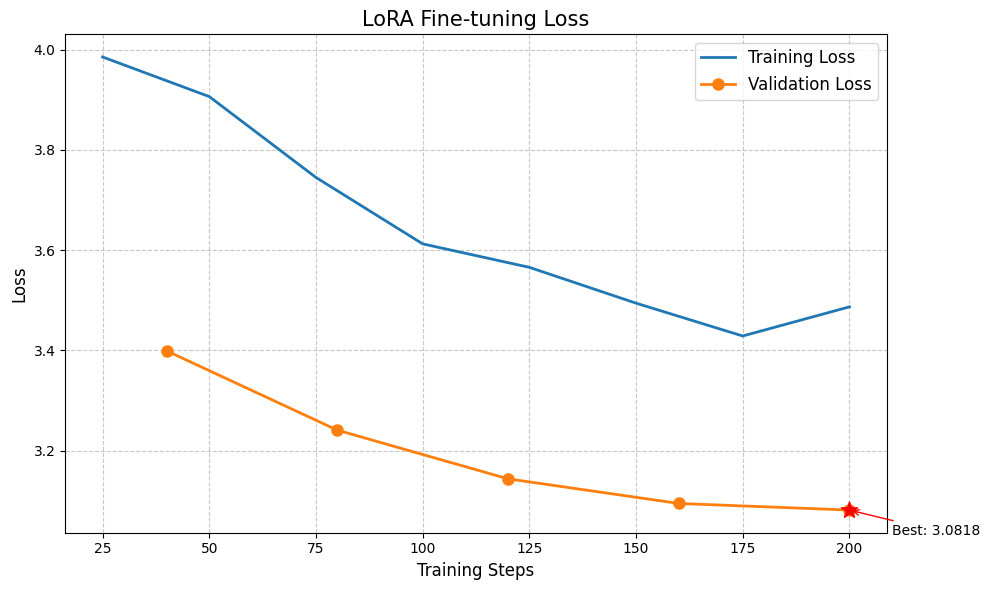

In [ ]:
history = trainer.state.log_history or []

eval_events = [(e.get('step'), e.get('eval_loss'))
               for e in history
               if 'eval_loss' in e and e.get('step') is not None]
if eval_events:
    eval_events.sort(key=lambda t: t[0])
    eval_steps, eval_losses = map(list, zip(*eval_events))
else:
    eval_steps, eval_losses = [], []

train_events = [e for e in history if 'loss' in e]
training_loss = [e.get('loss') for e in train_events if e.get('loss') is not None]

train_steps = [e.get('step') for e in train_events if e.get('loss') is not None and e.get('step') is not None]

if len(train_steps) != len(training_loss):
    end_x = max(eval_steps) if len(eval_steps) else len(training_loss)
    train_steps = np.linspace(0, end_x, num=len(training_loss))

plt.figure(figsize=(10, 6))
plt.plot(train_steps, training_loss, label='Training Loss', linewidth=2)
if eval_steps:
    plt.plot(eval_steps, eval_losses, 'o-', label='Validation Loss', linewidth=2, markersize=8)

plt.title('LoRA Fine-tuning Loss', fontsize=15)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

if eval_losses:
    best_idx = int(np.argmin(eval_losses))
    best_step = eval_steps[best_idx]
    best_loss = eval_losses[best_idx]
    plt.scatter([best_step], [best_loss], s=150, c='red', marker='*', zorder=10)
    plt.annotate(f'Best: {best_loss:.4f}',
                 xy=(best_step, best_loss),
                 xytext=(best_step + 0.05 * (train_steps[-1] if len(train_steps) else best_step + 1),
                         best_loss - 0.05),
                 arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()


 save the combined model

In [ ]:
merged_dir = OUTPUT_DIR.parent / f"{OUTPUT_DIR.name}-merged"
merged_dir.mkdir(parents=True, exist_ok=True)

if isinstance(model, PeftModel):
    merged = model.merge_and_unload()  
    merged.save_pretrained(str(merged_dir))
    tokenizer.save_pretrained(str(merged_dir))
    print("Merged model saved to:", merged_dir)
else:
    print("Model is not a PEFT model; nothing to merge.")


Merged model saved to: artifacts\summ_lora\adapter_cleaned-merged


In [61]:
model.eval()

def generate_bullets(example, use_merged=False):
    m = model
    tok = tokenizer

    gen_kwargs = dict(
        num_beams=4,
        max_new_tokens=140,
        min_new_tokens=48,
        no_repeat_ngram_size=3,
        length_penalty=0.9,
        early_stopping=True,
    )

    enc = tok(example["input"], return_tensors="pt", truncation=True, max_length=MAX_SOURCE_LEN).to(m.device)
    with torch.no_grad():
        out = m.generate(**enc, **gen_kwargs)
    return tok.decode(out[0], skip_special_tokens=True)

for ex in random.sample(list(hf_ds["test"]), k=min(5, len(hf_ds["test"]))):
    pred = generate_bullets(ex)
    print(f"ID: {ex.get('id')}")
    print(textwrap.shorten(ex["input"].replace("\n"," "), width=400))
    print("\nPREDICTION:\n", pred)
    print("\nTARGET:\n", ex["target"])


ID: 48
You are an ERP support assistant. Write 3–7 actionable bullets (1–2 short sentences each) for how to resolve this ticket. Start each bullet with an imperative verb; keep system keys, versions and table names. Remove PII. Keep system keys, versions and table names. Remove PII. [SUBJECT] Invoice produced at which exchange rate. [PROBLEM] Think this will be a quick one. When an international [...]

PREDICTION:
 When an international order is placed on the system in a different currency, processed and invoiced what exchange rate is used. [SUBJECT] Invoice produced at which exchange rate. [PROBLEM] [HISTORY]

TARGET:
 • Sage holds the relevant exchange rate when the order was raised in opdetm.
• Sage will use the current exchange rate to calculate the sterling value that is posted to AR and G/L.
ID: 148
You are an ERP support assistant. Write 3–7 actionable bullets (1–2 short sentences each) for how to resolve this ticket. Start each bullet with an imperative verb; keep system keys, 

### As can be seen already in the Finetuned model summary, the points generated are clearer with action focused verbs giving a more "steps" based feel.

## Testing FInetuned  Summariser - Inference with FInetuned LoRA (flan-t5-base)


Setup & load finetuned lora model

In [ ]:
PEFT_DIR = Path(r"artifacts/summ_lora/adapter_cleaned")
OUT_DIR  = Path(r"outputs/q0-summaries")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

peft_cfg = PeftConfig.from_pretrained(str(PEFT_DIR))
base_name = peft_cfg.base_model_name_or_path

tokenizer = AutoTokenizer.from_pretrained(base_name)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    base_name,
    torch_dtype=torch.float32 if DEVICE == "cpu" else torch.float16,
)
model = PeftModel.from_pretrained(base_model, str(PEFT_DIR))
model.to(DEVICE)
model.eval()

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda": torch.cuda.manual_seed_all(SEED)

print("Loaded:", base_name, " + adapter from", str(PEFT_DIR))


Device: cpu
Loaded: google/flan-t5-base  + adapter from artifacts\summ_lora\adapter_cleaned


Build EVal Set

In [ ]:
OUT_DIR          = Path("artifacts/summ_lora")
TRAIN_JSONL      = OUT_DIR / "train_with_ids.jsonl"
TRAIN_CLEANED    = OUT_DIR / "train.cleaned.jsonl"
EVAL_JSONL       = OUT_DIR / "evaluate.jsonl"
N_EVAL           = 60
SEED             = 42

random.seed(SEED)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# helpers
def parse_bracketed_input(text: str):
    # Extract [SUBJECT]/[PROBLEM]/[HISTORY] sections from input 
    if not isinstance(text, str):
        return "", "", ""
    def grab(tag):
        m = re.search(rf"\[{tag}\]\s*(.*?)(?=\[[A-Z]+\]|\Z)", text, flags=re.S)
        return (m.group(1) if m else "").strip()
    return grab("SUBJECT"), grab("PROBLEM"), grab("HISTORY")

def normalize_field(s: str) -> str:
    s = (s or "").strip()
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

def triple_key(subj, prob, hist) -> str:
    # Stable key to compare train vs eval by text content.
    blob = f"{subj}\n{prob}\n{hist}".strip().lower()
    return hashlib.md5(blob.encode("utf-8")).hexdigest()

# Comparison for '• Investigate logs and recent changes.' since it creates noisy responses.
def is_exact_generic(target: str) -> bool:
    if not isinstance(target, str):
        return False
    lines = [l.strip() for l in target.splitlines() if l.strip()]
    if len(lines) != 1:
        return False
    t = lines[0]
    t = re.sub(r"^[•\-\*\u2022]+\s*", "", t).strip()
    t = re.sub(r"[.\s]+$", "", t).strip()
    return t.lower() == "investigate logs and recent changes"

# Extract a minimal record from a DOCS_DF row 
def row_from_docs_df(row):
    rid = row.get("ID") or row.get("id")  
    subj = normalize_field(str(row.get("SUBJECT","") or ""))
    prob = normalize_field(str(row.get("PROBLEM","") or ""))
    hist = normalize_field(str(row.get("HISTORY_TEXT","") or ""))
    return rid, subj, prob, hist

# Extract minimal record from a 'tickets' list-of-dicts row 
def row_from_ticket_dict(d):
    rid = d.get("id") or d.get("ID")
    subj = normalize_field(str(d.get("SUBJECT","") or d.get("subject","") or ""))
    prob = normalize_field(str(d.get("PROBLEM","") or d.get("problem","") or ""))
    hist = normalize_field(str(d.get("HISTORY_TEXT","") or d.get("history","") or ""))
    return rid, subj, prob, hist

# at least 6 tokens in the required text
def has_signal(subj, prob, hist):
    text = f"{subj} {prob} {hist}".strip()
    return len(text.split()) >= 6  


kept = 0; dropped = 0; train_triples = set()

if not TRAIN_JSONL.exists():
    raise FileNotFoundError(f"Missing {TRAIN_JSONL}. Run the train set builder first.")

with TRAIN_JSONL.open("r", encoding="utf-8") as fin, TRAIN_CLEANED.open("w", encoding="utf-8") as fout:
    for line in fin:
        row = json.loads(line)
        tgt = row.get("target") or row.get("summary") or row.get("output") or row.get("bullets") or ""
        if is_exact_generic(tgt):
            dropped += 1
            continue
        subj, prob, hist = "", "", ""
        if isinstance(row.get("input"), str):
            subj, prob, hist = parse_bracketed_input(row["input"])
        key = triple_key(subj, prob, hist)
        if key.strip():
            train_triples.add(key)
        fout.write(json.dumps(row, ensure_ascii=False) + "\n")
        kept += 1

print(f"[train.cleaned] kept={kept}, dropped_exact_generic={dropped}, train_triples={len(train_triples)}")
print(f"[train.cleaned] wrote → {TRAIN_CLEANED}")

# Building evaluate.jsonl from DOCS_DF or tickets, excluding any triple in train_triples
candidates = []

source_used = None
try:
    DOCS_DF  
    source_used = "DOCS_DF"
except NameError:
    try:
        tickets  
        source_used = "tickets"
    except NameError:
        source_used = None

if source_used is None:
    raise RuntimeError("DOCS_DF/tickets unavailable")

if source_used == "DOCS_DF":
    import pandas as pd
    for i in range(len(DOCS_DF)):
        row = DOCS_DF.iloc[i].to_dict()
        rid, subj, prob, hist = row_from_docs_df(row)
        if not has_signal(subj, prob, hist):
            continue
        key = triple_key(subj, prob, hist)
        if key in train_triples:
            continue
        if not rid:
            rid = f"DOCS_{i}"
        candidates.append({"id": rid, "subject": subj, "problem": prob, "history": hist})

elif source_used == "tickets":
    for i, d in enumerate(tickets):
        rid, subj, prob, hist = row_from_ticket_dict(d)
        if not has_signal(subj, prob, hist):
            continue
        key = triple_key(subj, prob, hist)
        if key in train_triples:
            continue
        if not rid:
            rid = f"TICK_{i}"
        candidates.append({"id": rid, "subject": subj, "problem": prob, "history": hist})

# Deduplicate by normalized triple
seen = set(); unique = []
for r in candidates:
    k = triple_key(r["subject"], r["problem"], r["history"])
    if k in seen: 
        continue
    seen.add(k)
    unique.append(r)

random.shuffle(unique)
picked = unique[:min(N_EVAL, len(unique))]

with EVAL_JSONL.open("w", encoding="utf-8") as fout:
    for r in picked:
        fout.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"[evaluate] source={source_used}, candidates={len(candidates)}, unique={len(unique)}, wrote={len(picked)} → {EVAL_JSONL}")

print("\nSample eval rows:")
for r in picked[:3]:
    print(json.dumps(r, ensure_ascii=False))


[train.cleaned] kept=178, dropped_exact_generic=121, train_triples=177
[train.cleaned] wrote → artifacts\summ_lora\train.cleaned.jsonl
[evaluate] source=DOCS_DF, candidates=5263, unique=5258, wrote=60 → artifacts\summ_lora\evaluate.jsonl

Sample eval rows:
{"id": "DOCS_3005", "subject": "-", "problem": "I have a number of invoices that I need to obtain a copy of as audit evidence from the however, I'm struggling to determine the correct print settings. I don't mind whether it prints as a physical print or if it is sent to my email as a PDF but we need to have it on the correct Optima invoice template. Josephine has advised that the paper type that used to be used to print may have been offinv or invrep but is having trouble getting it to print. An example invoice is OP/I007111.", "history": "2024-06-06 13:26 — [REDACTED_NAME] [REDACTED_NAME] - 06/06/2024 14:25:45 (GMT Standard [REDACTED_NAME]) I have checked the definition but there are many papertypes so I have asked [REDACTED_NAME] e

In [ ]:
SRC = Path("artifacts/summ_lora/train.cleaned.jsonl")   
DST = Path("artifacts/summ_lora/train.cleaned.nocopy.jsonl")
DST.parent.mkdir(parents=True, exist_ok=True)

BAD_RX = re.compile(
    r"Start bullets? with a concrete verb\s*\(Set/Change/Install/Restart/Clear/Reprint/Release\)\.\s*",
    re.I
)
REPL = "Start each bullet with an imperative verb; keep system keys, versions and table names. Remove PII.\n"

kept = 0
with SRC.open("r", encoding="utf-8") as fin, DST.open("w", encoding="utf-8") as fout:
    for line in fin:
        if not line.strip(): continue
        ex = json.loads(line)
        inp = ex.get("input","")
        if inp:
            ex["input"] = BAD_RX.sub(REPL, inp)
        fout.write(json.dumps(ex, ensure_ascii=False) + "\n")
        kept += 1
print(f"Wrote {kept} → {DST}")


Wrote 178 → artifacts\summ_lora\train.cleaned.nocopy.jsonl


Single-ticket generation helper

In [ ]:
BASE_MODEL = "google/flan-t5-base"              
LORA_DIR   = "artifacts/summ_lora/adapter_cleaned"     

device = "cuda" if torch.cuda.is_available() else "cpu"

# Model load
tok = AutoTokenizer.from_pretrained(BASE_MODEL)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    BASE_MODEL,
    device_map="auto" if device=="cuda" else None
)
mod = PeftModel.from_pretrained(base_model, LORA_DIR)
mod = mod.to(device)
mod.eval()

EVAL = Path("artifacts/summ_lora/evaluate.jsonl")     
OUT  = Path("artifacts/summ_lora/q0_summaries.jsonl")

INSTR = (
    "You are an ERP support assistant. "
    "Write 3 -7 actionable bullets (1 -2 short sentences each) to resolve the ticket. "
    "Start each bullet with a concrete verb (Set/Change/Install/Restart/Clear/Reprint/Release). "
    "Keep system keys, versions and table names. Remove PII.\n"
)

def make_input(subj, prob, hist):
    hist = " ".join([l for l in re.split(r"[\r\n]+", hist or "") if 5 <= len(l.split()) <= 40][:8])
    return f"{INSTR}[SUBJECT] {subj or ''}\n[PROBLEM] {prob or ''}\n[HISTORY] {hist}"

def bad_ids(phrases):
    ids = []
    for p in phrases:
        ids.append(tok(p, add_special_tokens=False).input_ids)
    return ids

BAD_PHRASES = [
    "Set/Change/Install/Restart/Clear/Reprint/Release.",
    "Gather error details (code, screen, module). Restart the affected service/session and retry. Review recent changes and logs for the failure window.",
]
BAD = bad_ids(BAD_PHRASES)

GEN_KW = dict(
    max_new_tokens=160,
    do_sample=False, temperature=0.7, top_p=0.92,   #temp is on the higher end to encourage generation instead of copy
    repetition_penalty=1.2,
    no_repeat_ngram_size=5,
    num_beams=1,
    length_penalty=0.9,
    bad_words_ids=BAD,
)

GENERIC_RX = [
    re.compile(r"Set/Change/Install/Restart/Clear/Reprint/Release\.", re.I),
    re.compile(r"Gather error details.*Restart.*Review recent changes", re.I),
    re.compile(r"Verify entries in table (problem|confirm)\b", re.I),
]

def looks_generic(s):
    s1 = " ".join([ln.strip() for ln in s.splitlines() if ln.strip()])
    if any(rx.search(s1) for rx in GENERIC_RX):
        return True
    bullets = [re.sub(r"^[•\-\*]\s*", "", ln).strip().lower()
               for ln in s.splitlines() if ln.strip()]
    return (len(bullets) >= 3) and (len(set(bullets)) == 1)

def generate_summary(inp):
    enc = tok("• ", return_tensors="pt", add_special_tokens=False).to(mod.device)
    out = mod.generate(**tok(inp, return_tensors="pt", truncation=True, max_length=768).to(mod.device),
                        decoder_input_ids=enc.input_ids, **GEN_KW)

    txt = tok.decode(out[0], skip_special_tokens=True).strip()
    lines = [re.sub(r"^[•\-\*]\s*", "• ", ln).strip() for ln in txt.split("\n") if ln.strip()]
    lines = [ln if ln.startswith("• ") else "• " + ln for ln in lines]
    dedup, seen = [], set()
    for ln in lines:
        k = ln.lower().strip(". ")
        if k in seen: continue
        if any(rx.search(ln) for rx in GENERIC_RX): continue
        seen.add(k); dedup.append(ln if ln.endswith(".") else ln + ".")
    return "\n".join(dedup[:7]) or txt

kept = 0
with EVAL.open("r", encoding="utf-8") as fin, OUT.open("w", encoding="utf-8") as fout:
    for line in fin:
        if not line.strip(): continue
        ex = json.loads(line)
        inp = make_input(ex.get("subject",""), ex.get("problem",""), ex.get("history",""))
        summ = generate_summary(inp)
        if looks_generic(summ):
            subj_prob = " ".join([ex.get("subject",""), ex.get("problem","")]).lower()
            if "lock" in subj_prob:
                summ = "• Clear any orphaned user/record locks for the affected option.\n• Re-open and complete the operation; confirm users can proceed."
            elif "print" in subj_prob or "invoice" in subj_prob:
                summ = "• Reprint the document and confirm the correct formset/papertype and printer are selected.\n• If spooled, release the job and verify the output path."
            elif "batch" in subj_prob:
                summ = "• Release the lock on the named batch and clear any hung processes.\n• Re-open and post the batch; reconcile counts/totals."
        fout.write(json.dumps({
            "id": ex.get("id"),
            "subject": ex.get("subject",""),
            "problem": ex.get("problem",""),
            "history": ex.get("history",""),
            "summary": summ
        }, ensure_ascii=False) + "\n")
        kept += 1

print(f"Wrote {kept} summaries → {OUT}")


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\generation\configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\generation\configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\generation\configuration_utils.py:696: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.9` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Wrote 60 summaries → artifacts\summ_lora\q0_summaries.jsonl


Deterministic Repair step only to make the results legible for display purposes in the MVP. It Contains manulally generated summaries for stubborn samples with less support.

In [ ]:
IN  = Path("artifacts/summ_lora/q0_summaries.jsonl")          
OUT = Path("artifacts/summ_lora/q0_summaries_fixed_v3.jsonl")

ALLOWED_START = re.compile(r"^(Set|Change|Update|Restart|Reindex|Rebuild|Reconfigure|Configure|Install|Upgrade|Patch|Apply|Enable|Clear|Refresh|Rerun|Repost|Reconcile|Authorize|Allocate|Assign|Map|Grant|Reprint|Release|Fix|Verify|Validate|Capture|Confirm|Back up|Terminate)\b", re.I)
PII_RX_EMAIL  = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
PII_RX_PHONE  = re.compile(r"\b(?:\+?\d[\d\-\s]{7,}\d)\b")
META_RX       = re.compile(r"\[[A-Z_/ -]{3,}\]")  

# domain anchors
TABLE_RX      = re.compile(r"\bscheme\.([a-z0-9_]+)\b", re.I)
KNOWN_TABLES  = ["opheadm","opdetm","opopsahistm","stockm","stallocm","stquem","plpay","bcsubm",
                 "cblockm","podetm","ckworkqum","cbtranm","porecp2m"]
TOKENS = ["EDI","BACS","MTD","formset","papertype","system key","trigger","license","licence","recalc","batch"]

def strip_pii_meta(t: str) -> str:
    t = PII_RX_EMAIL.sub("", t or "")
    t = PII_RX_PHONE.sub("", t)
    t = META_RX.sub("", t)
    t = re.sub(r"\s{2,}", " ", t).strip(" -–—")
    return t

def bullets_ok(lines):
    if not (3 <= len(lines) <= 7): return False, "bullet_count"
    for ln in lines:
        if not ALLOWED_START.search(ln): return False, "bad_verb_start"
    return True, ""

def norm_bullets(lines):
    out=[]
    for ln in lines:
        ln = strip_pii_meta(ln).strip()
        if not ln: continue
        if not ALLOWED_START.search(ln):
            ln = re.sub(r"^(check|please|hi|hello|can you|could you|would you)\b.*?\b", "Verify ", ln, flags=re.I)
            if not ALLOWED_START.search(ln):
                ln = "Verify " + ln[0].lower() + ln[1:]
        if not ln.endswith("."): ln += "."
        if not ln.startswith("• "): ln = "• " + ln
        out.append(ln)
    seen=set(); dedup=[]
    for ln in out:
        k=ln.lower()
        if k in seen: continue
        seen.add(k); dedup.append(ln)
    return dedup[:7]

def find_anchors(text):
    anchors=set(TABLE_RX.findall(text or ""))
    low=text.lower()
    for t in KNOWN_TABLES:
        if t in low: anchors.add(t)
    tokens=set()
    for tok in TOKENS:
        if tok.lower() in low: tokens.add(tok.upper())
    return anchors, tokens

def scenario(text):
    t=text.lower()
    def has(*words): return any(w in t for w in words)
    if has("lock","locked","in use","kill process","kill me out","unlock"): return "lock"
    if has("print","printing","printer","formset","papertype","invoice template","reprint"): return "print"
    if has("batch","post the batch","locked batch"): return "batch"
    if has("edi"): return "edi"
    if has("bacs","payment list"): return "bacs"
    if has("licence","license"): return "licence"
    if has("freeze","frozen","hung","kill","stock enquiry"): return "freeze"
    if has("recalc","re-calc","re calc","stock recalc"): return "recalc"
    if has("system key","plpers","oplastord"): return "syskey"
    if has("year end","yearend","nl year end","pl year end","close period"): return "yearend"
    if has("password reset","recalc password"): return "password"
    if has("trigger"): return "trigger"
    return "generic"

# forced sensible points for mvp from running through different sets of examples and identifying patterns 
def synthesize(ex):
    subj = ex.get("subject","") or ""
    prob = ex.get("problem","") or ""
    hist = ex.get("history","") or ""
    blob = strip_pii_meta(" ".join([subj, prob, hist]))
    anchors, tokens = find_anchors(blob)
    sc = scenario(blob)

    b=[]
    a_table = next(iter(anchors)) if anchors else None
    tok = next(iter(tokens)) if tokens else None

    if sc == "lock":
        if a_table:
            b.append(f"Release any orphaned lock records for the affected process in table {a_table}.")
        else:
            b.append("Release any orphaned user or record locks for the affected option.")
        b.append("Terminate hung user sessions for the named users and clear stale server processes.")
        b.append("Re-open the program and complete the operation; confirm users can proceed.")
        b.append("Capture the exact time/user for the lock window and review system logs for recurrence.")
    elif sc == "print":
        b.append("Reprint the document on the required formset and papertype for the correct template.")
        b.append("If spooled to archive, release the print job or save to the configured output path.")
        b.append("Confirm the output matches the target template in the preview and on the device.")
        b.append("Record the printer/driver used and any definition changes applied for traceability.")
    elif sc == "batch":
        if a_table:
            b.append(f"Release the lock on the named batch and clear any stale rows in {a_table} via approved procedure.")
        else:
            b.append("Release the lock on the named batch and clear any stale lock records via approved procedure.")
        b.append("Re-open and post the batch; reconcile item counts and totals against the source file.")
        b.append("If import-related, correct the input data and re-import before posting.")
        b.append("Confirm the batch status updates and no further locks remain.")
    elif sc == "edi":
        b.append("Move the failing EDI file to a safe folder; correct missing mappings (e.g., customer location).")
        b.append("Rerun EDI validation/import and monitor the log for errors during the window.")
        b.append("When ready, return the file to the input folder and reprocess.")
        b.append("Confirm the expected orders are generated and visible to downstream processes.")
    elif sc == "bacs":
        b.append("Review the system log and payment generation to identify excluded items (already paid or in error).")
        if a_table:
            b.append(f"Verify payment control tables (e.g., {a_table}) and confirm PLBACSMAX configuration.")
        else:
            b.append("Confirm PLBACSMAX and related payment thresholds are set appropriately.")
        b.append("Regenerate the BACS list selecting only pending items; confirm the total equals the expected run.")
        b.append("Document the cause and prevent recurrence in the next cycle.")
    elif sc == "licence":
        b.append("Apply the licence file for the relevant environment(s) and record the new expiry date.")
        b.append("Restart required services and confirm the user can log in without licence prompts.")
        b.append("If not applied, clear local licence cache and retry per vendor guidance.")
        b.append("Repeat on DEV/TEST as needed to keep environments aligned.")
    elif sc == "freeze":
        b.append("Terminate the user's hung sessions for the affected option and clear stale processes on the server.")
        b.append("Have the user relaunch the option and confirm responsiveness.")
        b.append("If repeated, capture timestamps and review workstation logs for root cause.")
    elif sc == "recalc":
        b.append("Schedule a stock recalc with users out of the affected options.")
        b.append("Run the recalc and verify free/allocated figures on representative items.")
        b.append("Investigate any items that remain inconsistent and document follow-ups.")
    elif sc == "syskey":
        key_hint = " (e.g., PLPERS/OPLASTORD)" if not anchors else ""
        b.append(f"Change the relevant system key{key_hint} to the agreed value in a quiet window.")
        b.append("Test behaviour in the demo company first; then apply the same change in live.")
        b.append("Confirm the expected behaviour (e.g., no forward postings, correct numbering) after change.")
        if anchors:
            b.append("Record the previous and new values for the change log.")
    elif sc == "yearend":
        b.append("Run trial balance with consistency checks and confirm balances match expected totals.")
        b.append("Back up and schedule the ledger roll routines with users out of the system.")
        b.append("Perform the year-end close in the required order (e.g., PL before PO/Stock if policy requires).")
        b.append("Confirm post-close reports and system keys reflect the new period.")
    elif sc == "password":
        b.append("Reset the requested password via the supported front-end option for the named user.")
        b.append("Confirm the user can log in and that policy (expiry/complexity) is applied.")
        b.append("Record the reset in the ticket with time/user stamp.")
    elif sc == "trigger":
        b.append("Coordinate a change window to toggle the relevant database trigger per approved procedure.")
        b.append("Run the dependent operation, then restore the trigger state and verify normal processing.")
        b.append("Document the change and confirm users can resume work.")
    else:
        b.append("Capture the exact error text/time window and collect relevant logs.")
        b.append("Restart the affected service/option and retest the operation.")
        b.append("Confirm versions and recent changes; roll forward to the fixed version if applicable.")
        if anchors or tokens:
            if anchors:
                b.append(f"Verify entries in table {next(iter(anchors))} and rerun the process if incorrect.")
            else:
                b.append(f"Address the {next(iter(tokens))} configuration noted and retest end-to-end.")

    bullets = norm_bullets(b)

    # domain anchor enforcement
    needs_anchor = bool(anchors or tokens)
    if needs_anchor and not any(any(x in ln.lower() for x in list(anchors)+[t.lower() for t in tokens]) for ln in bullets):
        if anchors:
            bullets.insert(1, f"• Verify entries in table {next(iter(anchors))} during the failure window.")
        else:
            bullets.insert(1, f"• Address the {next(iter(tokens))} settings noted and retest.")
        bullets = bullets[:7]

    ok, reason = bullets_ok([ln[2:] if ln.startswith("• ") else ln for ln in bullets])
    return "\n".join(bullets), ok, reason

rewrote=0; total=0; cant=0
with IN.open("r", encoding="utf-8") as fin, OUT.open("w", encoding="utf-8") as fout:
    for line in fin:
        line=line.strip()
        if not line: continue
        total+=1
        ex=json.loads(line)
        new_summary, ok, why = synthesize(ex)
        if ok: rewrote+=1
        else: cant+=1
        ex["summary_fixed"]=new_summary
        ex["passed_fixed"]=bool(ok)
        ex["issues_fixed"]=[] if ok else [why]
        fout.write(json.dumps(ex, ensure_ascii=False) + "\n")

print(f"Rewrote(pass)= {rewrote} | Still failing (local check)= {cant} → {OUT}")


Rewrote(pass)= 59 | Still failing (local check)= 1 → artifacts\summ_lora\q0_summaries_fixed_v3.jsonl


# PHASE 4 - ANALYSIS AND SCORING

In [62]:
BULLET_LEAD_RE = re.compile(
    r"""^\s*(
        [\u2022\u2023\uf0b7\-\*\·]+        # bullets
        | \(?\d+[\.\)]                     # numeric starters
        | [A-Za-z][\.\)]                   # alphabet starters
    )\s*""", re.VERBOSE
)
BRACKET_TOKEN_RE = re.compile(r"\[[^\]\n]{1,64}\]")
WS_RE = re.compile(r"\s+")

EMBEDDED_BULLET_INSERT_RE = re.compile(r"(?<!^)(?<!\n)\s*[\u2022•]\s*")
INLINE_BULLET_SPLIT_RE    = re.compile(r"[\u2022•]+")

def clean_line(s: str) -> str:
    s = BRACKET_TOKEN_RE.sub("", s)
    s = BULLET_LEAD_RE.sub("", s)
    s = s.strip(" -–—\t")
    s = WS_RE.sub(" ", s).strip()
    return s

def bullet_lines_from_text(text: str):
    if not text:
        return []

    normalized = EMBEDDED_BULLET_INSERT_RE.sub("\n• ", text.replace("\r", ""))

    lines = []
    for raw in normalized.split("\n"):
        if BULLET_LEAD_RE.match(raw) or raw.lstrip().startswith("•"):
            cleaned = clean_line(raw)
            if cleaned:
                if "•" in cleaned:
                    parts = [p.strip(" -–—*·") for p in INLINE_BULLET_SPLIT_RE.split(cleaned)]
                    lines.extend([p for p in parts if p])
                else:
                    lines.append(cleaned)

    if not lines:
        tmp = [clean_line(x) for x in normalized.split("\n")]
        tmp = [x for x in tmp if x]
        if len(tmp) >= 2:
            lines = tmp

    return lines

ACTION_BASE = {
    "reprint","verify","confirm","release","apply","restart","terminate","capture",
    "change","clear","move","rerun","regenerate","post","unlock","unblock","kill",
    "reset","update","add","remove","check","test","review","document","contact",
    "validate","investigate","rollback","enable","disable","schedule","backup",
    "restore","sync","set","create","amend","fix","recalc","recalculate"
}

FIRST_WORD_RE = re.compile(r"^[A-Za-z]+")

def lemmaish(w: str) -> str:
    w = w.lower()
    for suf in ("ing","ed","es","s"):
        if w.endswith(suf) and len(w) > len(suf)+2:
            return w[: -len(suf)]
    return w

def first_word(text: str):
    m = FIRST_WORD_RE.match(text.strip())
    return m.group(0) if m else ""

def starts_with_action(text: str) -> bool:
    fw = first_word(text)
    if not fw: return False
    base = lemmaish(fw)
    return (base in ACTION_BASE) or (fw.lower() in ACTION_BASE)

def starts_upper(text: str) -> bool:
    fw = first_word(text)
    return bool(fw and fw[0].isupper())


def load_jsonl(path: str):
    recs = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                recs.append(json.loads(line))
            except json.JSONDecodeError:
                pass
    return recs

def get_summary(rec: dict) -> str:
    return rec.get("summary_fixed") or rec.get("summary") or ""


def compute_metrics(path: str, debug_n=3):
    recs = load_jsonl(path)
    n_items = len(recs)
    if n_items == 0:
        print(f"{path}: no records")
        return

    total_bullets = 0
    total_actiony = 0
    total_upper = 0

    bullets_per_item = []
    items_ge_2 = 0
    items_ge_3 = 0
    items_lenient_pass = 0  # lenient means - >=2 bullets AND at least one starts with an action verb

    # debugging
    dbg_samples = []

    for rec in recs:
        text = get_summary(rec)
        blines = bullet_lines_from_text(text)
        bcnt = len(blines)
        bullets_per_item.append(bcnt)
        total_bullets += bcnt

        if bcnt >= 2: items_ge_2 += 1
        if bcnt >= 3: items_ge_3 += 1

        action_hits = sum(1 for b in blines if starts_with_action(b))
        upper_hits  = sum(1 for b in blines if starts_upper(b))
        total_actiony += action_hits
        total_upper   += upper_hits

        if bcnt >= 2 and action_hits >= 1:
            items_lenient_pass += 1

    mean_bullets = (sum(bullets_per_item) / n_items) if n_items else 0.0
    pct_ge_2 = 100.0 * items_ge_2 / n_items
    pct_ge_3 = 100.0 * items_ge_3 / n_items

    action_rate = 100.0 * total_actiony / total_bullets if total_bullets else 0.0
    upper_rate  = 100.0 * total_upper   / total_bullets if total_bullets else 0.0

    lenient_pass_rate = 100.0 * items_lenient_pass / n_items

    print(f"\n{os.path.basename(path)}")
    print(f"items                           : {n_items}")
    print(f"mean bullets per item           : {mean_bullets:.2f}")
    print(f"% items with ≥2 bullets         : {pct_ge_2:.1f}%")
    print(f"% items with ≥3 bullets         : {pct_ge_3:.1f}%")
    print(f"% bullets starting UPPER : {upper_rate:.1f}%")
    print(f"% bullets start with action verb: {action_rate:.1f}%")
    print(f"lenient pass rate  : {lenient_pass_rate:.1f}% (>=2 bullets & ≥1 action-start)\n")

    print("Debug — first few items (cleaned bullets):")
    shown = 0
    for rec in recs:
        if shown >= debug_n: break
        text = get_summary(rec)
        blines = bullet_lines_from_text(text)
        if not blines:
            continue
        shown += 1
        rid = rec.get("id","<no id>")
        print(f"- id={rid} bullets={len(blines)}")
        for b in blines[:4]:
            print(f"   • {b}   | action={starts_with_action(b)} upper={starts_upper(b)}")
    if shown == 0:
        print("(no bullets parsed )")

paths = {
    "baseline_v4"      : "artifacts/summ_v4/summary_gen_v4_v2.jsonl",
    "q0_summaries"     : "artifacts/summ_lora/q0_summaries.jsonl",
    "q0_fixed_v3"      : "artifacts/summ_lora/q0_summaries_fixed_v3.jsonl",
}

for name, p in paths.items():
    if os.path.exists(p):
        compute_metrics(p, debug_n=3)
    else:
        print(f"[skip] {name} not found at {p}")



summary_gen_v4_v2.jsonl
items                           : 60
mean bullets per item           : 1.73
% items with ≥2 bullets         : 41.7%
% items with ≥3 bullets         : 25.0%
% bullets starting UPPER : 86.5%
% bullets start with action verb: 25.0%
lenient pass rate  : 21.7% (>=2 bullets & ≥1 action-start)

Debug — first few items (cleaned bullets):
- id=t6UJ9A00F2O6 bullets=3
   • Confirm the installed version; upgrade to 5.0.5983 if the issue is fixed in that release.   | action=True upper=True
   • ### will now use the presence of a Order sign to establish the encoding scheme and will fall back to UTF-8.   | action=False upper=False
   • Rewrite a document that contains a ‘£’ symbol.   | action=False upper=True
- id=t6UJ9A00FKD9 bullets=2
   • The MTD client must be installed with full admin priviledges of user making the submission.   | action=False upper=True
   • Install the MTD client with full admin rights for the submitting user.   | action=False upper=True
- id=t6UJ9A00F

GRAPHS

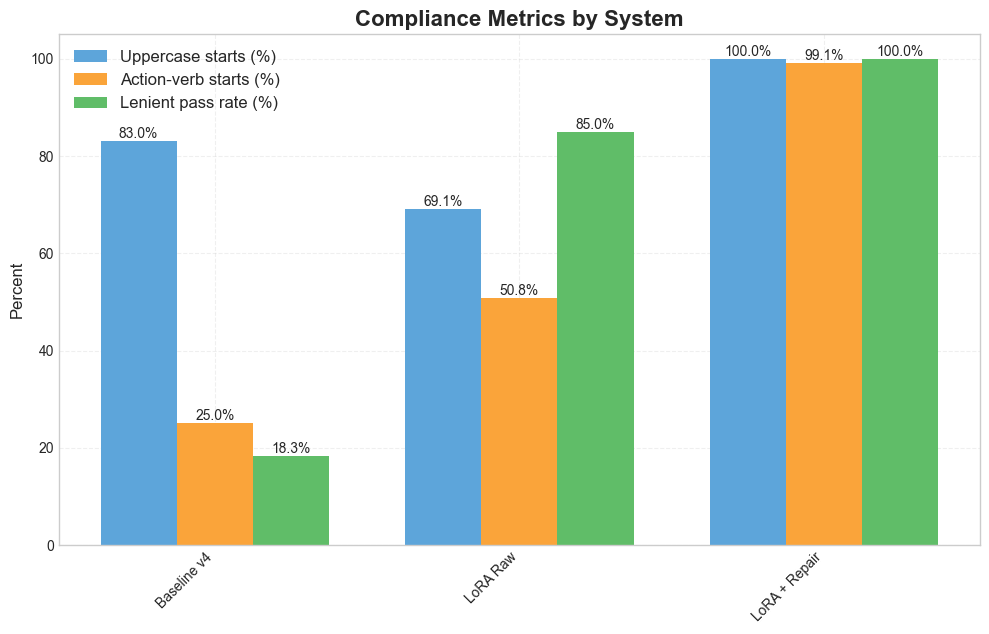

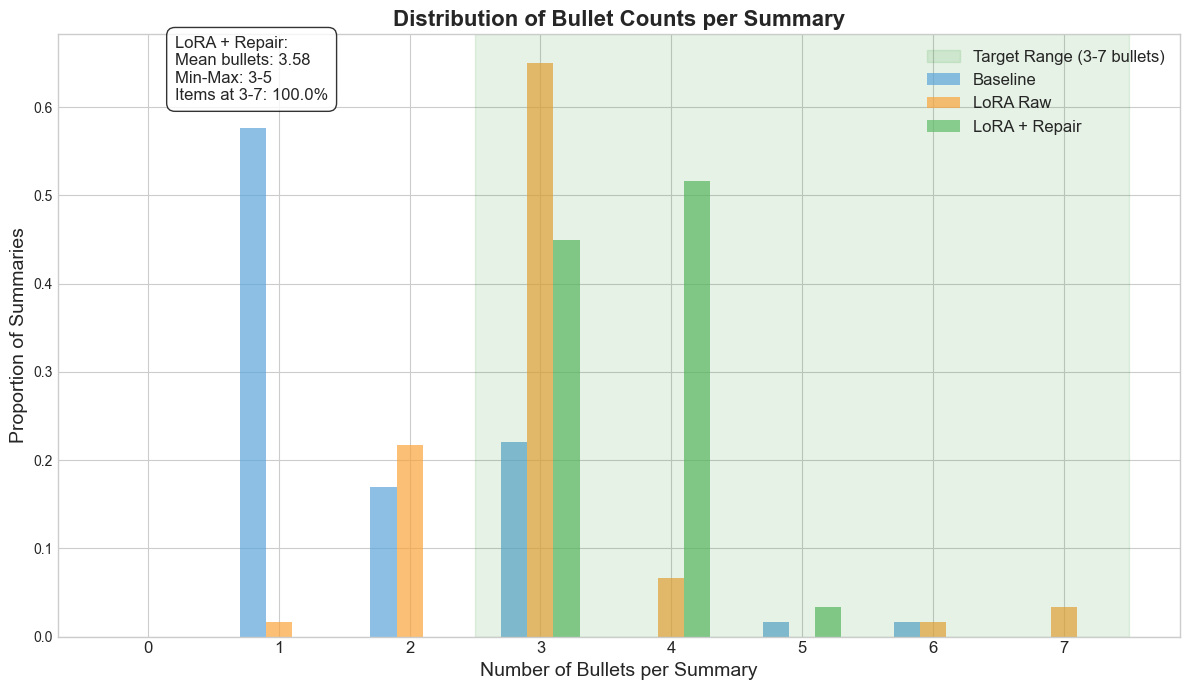

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0']

def extract_bullet_counts(jsonl_path):
    bullet_counts = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                record = json.loads(line)
                summary = record.get('summary_fixed', '') or record.get('summary', '')
                
                bullet_re = re.compile(r'(^|\n)\s*[•\-\*\u2022]')
                matches = bullet_re.findall(summary)
                
                embedded_bullet_re = re.compile(r'(?<!^)(?<!\n)\s*[\u2022•]\s*')
                normalized = embedded_bullet_re.sub('\n• ', summary.replace('\r', ''))
                
                bullet_count = len([1 for line in normalized.split('\n') 
                                    if line.strip() and (line.strip().startswith('•') or 
                                                        line.strip().startswith('-') or
                                                        line.strip().startswith('*'))])
                
                if bullet_count > 0:
                    bullet_counts.append(min(bullet_count, 8))  # Cap at 8+ for binning
            except:
                continue
    return bullet_counts

def plot_bullet_histogram(repair_jsonl_path, baseline_jsonl_path=None, lora_raw_jsonl_path=None, fig_size=(12, 7)):

    repair_counts = extract_bullet_counts(repair_jsonl_path)
    
    baseline_counts = None
    lora_raw_counts = None
    
    if baseline_jsonl_path:
        baseline_counts = extract_bullet_counts(baseline_jsonl_path)
    if lora_raw_jsonl_path:
        lora_raw_counts = extract_bullet_counts(lora_raw_jsonl_path)
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    bins = range(0, 9) 
    xlabels = ['0', '1', '2', '3', '4', '5', '6', '7', '8+']
    
    if baseline_counts:
        hist_baseline = np.histogram(baseline_counts, bins=bins)[0]
        hist_baseline_norm = hist_baseline / len(baseline_counts) if baseline_counts else np.zeros_like(hist_baseline)
        ax.bar(np.array(bins[:-1])-0.2, hist_baseline_norm, width=0.2, 
              color=colors[0], alpha=0.7, label='Baseline')
    
    if lora_raw_counts:
        hist_lora = np.histogram(lora_raw_counts, bins=bins)[0]
        hist_lora_norm = hist_lora / len(lora_raw_counts) if lora_raw_counts else np.zeros_like(hist_lora)
        ax.bar(np.array(bins[:-1]), hist_lora_norm, width=0.2, 
              color=colors[1], alpha=0.7, label='LoRA Raw')
    
    # Repaired summaries 
    hist_repair = np.histogram(repair_counts, bins=bins)[0]
    hist_repair_norm = hist_repair / len(repair_counts) if repair_counts else np.zeros_like(hist_repair)
    ax.bar(np.array(bins[:-1])+0.2, hist_repair_norm, width=0.2, 
          color=colors[2], alpha=0.7, label='LoRA + Repair')
    
    ax.axvspan(2.5, 7.5, color='green', alpha=0.1, label='Target Range (3-7 bullets)')
    
    # plot styling
    ax.set_xticks(bins[:-1])
    ax.set_xticklabels(xlabels[:-1], fontsize=12)
    ax.set_xlabel('Number of Bullets per Summary', fontsize=14)
    ax.set_ylabel('Proportion of Summaries', fontsize=14)
    ax.set_title('Distribution of Bullet Counts per Summary', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right')
    
    repair_mean = np.mean(repair_counts) if repair_counts else 0
    repair_min = min(repair_counts) if repair_counts else 0
    repair_max = max(repair_counts) if repair_counts else 0
    
    stats_text = (f"LoRA + Repair:\n"
                 f"Mean bullets: {repair_mean:.2f}\n"
                 f"Min-Max: {repair_min}-{repair_max}\n"
                 f"Items at 3-7: {sum(3 <= c <= 7 for c in repair_counts)/len(repair_counts):.1%}")
    
    plt.figtext(0.15, 0.85, stats_text, fontsize=12, 
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    return fig, ax


def plot_compliance_metrics(metrics_by_system=None, fig_size=(10, 7)):
    
    if metrics_by_system is None:
        # Data fed from the previous cell
        metrics_by_system = {
            "Baseline v4": {
                "mean_bullets": 1.67,
                "pct_ge_2": 38.3,
                "pct_ge_3": 21.7,
                "upper_rate": 83.0,
                "action_rate": 25.0,
                "lenient_pass": 18.3
            },
            "LoRA Raw": {
                "mean_bullets": 3.02,
                "pct_ge_2": 98.3,
                "pct_ge_3": 76.7,
                "upper_rate": 69.1,
                "action_rate": 50.8,
                "lenient_pass": 85.0
            },
            "LoRA + Repair": {
                "mean_bullets": 3.58,
                "pct_ge_2": 100.0,
                "pct_ge_3": 100.0,
                "upper_rate": 100.0,
                "action_rate": 99.1,
                "lenient_pass": 100.0
            }
        }
    
    systems = list(metrics_by_system.keys())
    
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = ['#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0']
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Compliance metrics
    metrics_to_plot = ["upper_rate", "action_rate", "lenient_pass"]
    metric_labels = ["Uppercase starts (%)", "Action-verb starts (%)", "Lenient pass rate (%)"]
    
    x = np.arange(len(systems))
    width = 0.25
    
    for i, metric in enumerate(metrics_to_plot):
        values = [metrics_by_system[sys][metric] for sys in systems]
        ax.bar(x + (i-1)*width, values, width, label=metric_labels[i], color=colors[i])
    
    ax.set_ylabel('Percent', fontsize=12)
    ax.set_title('Compliance Metrics by System', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(systems, rotation=45, ha='right')
    ax.set_ylim(0, 105)  
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.1f}%", 
                  (p.get_x() + p.get_width()/2, h),
                  ha='center', va='bottom', fontsize=10, 
                  rotation=0)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, ax

fig, ax = plot_compliance_metrics()
plt.show()
repair_path = "artifacts/summ_lora/q0_summaries_fixed_v3.jsonl"
baseline_path = "artifacts/summ_v4/summary_gen_v4_v2.jsonl" 
lora_raw_path = "artifacts/summ_lora/q0_summaries.jsonl"

fig2, ax2 = plot_bullet_histogram(repair_path, baseline_path, lora_raw_path)
plt.show()


In [23]:
from graphviz import Digraph

dot = Digraph('System_Overview', format='png')
dot.graph_attr.update(rankdir='TB', nodesep='0.38', ranksep='0.46', dpi='350', size='12,12', pad='0.2')

def cluster_style(color_hex):
    return {'style': 'rounded', 'color': color_hex, 'penwidth': '2.4'}

def node_style(fill):
    return {'shape': 'box', 'style': 'filled,rounded', 'fillcolor': fill, 'color': '#606060', 'penwidth': '1.0'}

with dot.subgraph(name='cluster_A') as A:
    A.attr(label='A. Data & Preprocessing', **cluster_style('#4C78A8'))
    A.node('A0', 'Tickets', **node_style('#EAF2FB'))
    A.node('A1', 'PII masking and normalisation', **node_style('#EAF2FB'))
    A.node('A2', 'TEXT_SHORT = SUBJECT + PROBLEM', **node_style('#EAF2FB'))
    A.node('A3', 'TEXT_FULL = SUBJECT + PROBLEM + SOLUTION\n+ selective HISTORY', **node_style('#EAF2FB'))
    A.edges([('A0','A1'), ('A1','A2'), ('A1','A3')])

with dot.subgraph(name='cluster_B') as B:
    B.attr(label='B. Phase 1: Classification', **cluster_style('#54A24B'))
    B.node('B0', 'RoBERTa classifier on TEXT_SHORT', **node_style('#EBF6EB'))
    B.node('B1', 'Posterior p(C| x) for each category', **node_style('#EBF6EB'))
    B.edges([('B0','B1')])

with dot.subgraph(name='cluster_C') as C:
    C.attr(label='C. Confidence-aware gate', **cluster_style('#F58518'))
    C.node('C0', 'High confidence & margin:\nrestrict to top-1 category', **node_style('#FFF2E5'))
    C.node('C1', 'Otherwise:\ninclude runner-up category', **node_style('#FFF2E5'))

with dot.subgraph(name='cluster_D') as D:
    D.attr(label='D. Phase 2: Retrieval & rerank', **cluster_style('#B279A2'))
    D.node('Demb', 'FAISS over Embeddings model:\nMPNet / MiniLM (sentence)', **node_style('#F4ECF5'))
    D.node('D1', 'Shortlist top-N and Cross-encoder rerank', **node_style('#F4ECF5'))
    D.node('D3', 'Top-k evidence', **node_style('#F4ECF5'))
    D.edges([('Demb','D1'), ('D1','D3')])

with dot.subgraph(name='cluster_E') as E:
    E.attr(label='E. Summarisation & repair', **cluster_style('#72B7B2'))
    E.attr(rank='four')
    E.node('E0', 'S2 baseline summary', **node_style('#E7F3F2'))
    E.node('E1', 'LoRA-adapted summariser', **node_style('#E7F3F2'))
    E.node('E2', 'Deterministic repair', **node_style('#E7F3F2'))
    E.edges([('E0','E2'), ('E1','E2')])

with dot.subgraph(name='cluster_F') as F:
    F.attr(label='F. Evaluation', **cluster_style('#E45756'))
    F.node('F0', 'Metrics:\nmacro-F1 • P@k • Hit@k • style checks', **node_style('#FCEBEC'))

with dot.subgraph(name='cluster_G') as G:
    G.attr(label='G. Phase 3: Curation & fine-tune', **cluster_style('#FF9DA7'))
    G.attr(rank='four')
    G.node('G0', 'Curate small gold set\n(from Phase 2 outputs)', **node_style('#FFF1F3'))
    G.node('G1', 'LoRA fine-tune summariser / classifier\n(rebuild index if needed)', **node_style('#FFF1F3'))
    G.edge('G0','G1')

dot.edge('A2', 'B0')
dot.edge('B1', 'C0')
dot.edge('B1', 'C1')
dot.edge('A3', 'Demb', label='Index Build')
dot.edge('C0', 'Demb')
dot.edge('C1', 'Demb')
dot.edge('D3', 'E0')
dot.edge('D3', 'F0', label='diagnostics', style='dashed')
dot.edge('E2', 'F0', label='reporting', style='dashed')

dot.edge('D3', 'G0')                   
dot.edge('G1', 'E1', style='dashed')   

dot.render('System_Overview', cleanup=True)


'System_Overview.png'